# Training a GCN

### Importing dependencies

In [2]:
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim

from sklearn.model_selection import train_test_split

from rdkit import Chem

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool


# Let's train a GCN on reduced features dataset (selected features)

In [32]:
data_reduced = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_dataset_turbidity.csv')

### Scaling down with Min-max standardization

In [33]:
data_reduced.columns

Index(['Unnamed: 0', 'di_name', 'tri_name', 'di_smiles', 'tri_smiles',
       'turbidity_binary', 'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_xlogp', 'di_tpsa', 'di_arom_group', 'tri_h_bond_acceptor_count',
       'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa', 'tri_arom_group'],
      dtype='object')

In [34]:
columns_to_scale = [
    'di_xlogp','di_tpsa', 
    'tri_xlogp', 'tri_tpsa'
]

scaler = MinMaxScaler()

data_reduced[columns_to_scale] = scaler.fit_transform(data_reduced[columns_to_scale])

data_reduced

,Unnamed: 0,di_name,tri_name,di_smiles,tri_smiles,turbidity_binary,di_h_bond_acceptor_count,di_h_bond_donor_count,di_xlogp,di_tpsa,di_arom_group,tri_h_bond_acceptor_count,tri_h_bond_donor_count,tri_xlogp,tri_tpsa,tri_arom_group
0,0,Di1,TriA,O=Cc1cccc(C=O)c1,Nc1nc(N)nc(N)n1,0,2,0,0.608696,0.000000,1,6.0,3.0,0.123711,0.775943,1
1,1,Di2,TriA,CC(C)(C)c1cc(C=O)c(O)c(C=O)c1,Nc1nc(N)nc(N)n1,0,3,1,0.826087,0.356766,1,6.0,3.0,0.123711,0.775943,1
2,2,Di3,TriA,O=Cc1cc2sc(C=O)cc2s1,Nc1nc(N)nc(N)n1,0,4,0,0.768116,0.992970,2,6.0,3.0,0.123711,0.775943,1
3,3,Di4,TriA,O=Cc1ccc(C=O)cc1,Nc1nc(N)nc(N)n1,0,2,0,0.565217,0.000000,1,6.0,3.0,0.123711,0.775943,1
4,4,Di5,TriA,O=Cc1c(F)c(F)c(C=O)c(F)c1F,Nc1nc(N)nc(N)n1,0,6,0,0.608696,0.000000,1,6.0,3.0,0.123711,0.775943,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,343,Di30,TriU,NCCOCCN,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,1,3,2,0.173913,0.478032,0,3.0,0.0,1.000000,0.000000,4
344,344,Di31,TriU,NCC1=CC(CN)=CC=C1,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,1,2,2,0.391304,0.314587,1,3.0,0.0,1.000000,0.000000,4
345,345,Di32,TriU,NCC(CN)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,1,3,3,0.101449,0.671353,0,3.0,0.0,1.000000,0.000000,4
346,346,Di33,TriU,NCCCC[C@H](N)C(=O)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,1,4,3,0.000000,0.970123,0,3.0,0.0,1.000000,0.000000,4


### Defining the SMILES to GRAPH conversion function

In [35]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum(), int(atom.GetDegree()), int(atom.GetIsAromatic())])
    
    atom_features = torch.tensor(atom_features, dtype=torch.float)
    
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append([i, j])
        edges.append([j, i])  
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() 
    
    data = Data(x=atom_features, edge_index=edge_index)
    return data


In [37]:
def is_valid_smiles(smiles):

    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None  
    except Exception as e:
        print(f"Error validating SMILES {smiles}: {e}")
        return False


### Controlling any SMILES errors

In [36]:
data_reduced['di_smiles_valid'] = data_reduced['di_smiles'].apply(is_valid_smiles)
data_reduced['tri_smiles_valid'] = data_reduced['tri_smiles'].apply(is_valid_smiles)

valid_rows = data_reduced[data_reduced['di_smiles_valid'] & data_reduced['tri_smiles_valid']]
invalid_rows = data_reduced[~(data_reduced['di_smiles_valid'] & data_reduced['tri_smiles_valid'])]
print(f"Invalid SMILES entries:\n{invalid_rows[['di_smiles', 'tri_smiles']]}")

Invalid SMILES entries:
Empty DataFrame
Columns: [di_smiles, tri_smiles]
Index: []


In [38]:
data_reduced.columns

Index(['Unnamed: 0', 'di_name', 'tri_name', 'di_smiles', 'tri_smiles',
       'turbidity_binary', 'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_xlogp', 'di_tpsa', 'di_arom_group', 'tri_h_bond_acceptor_count',
       'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa', 'tri_arom_group',
       'di_smiles_valid', 'tri_smiles_valid'],
      dtype='object')

### Creating the graph list of the SMILES

Only keys bond connections 

In [14]:
data_list = []

for index, row in data_reduced.iterrows():
    try:

        ditopic_graph = smiles_to_graph(row['di_smiles'])
        tritopic_graph = smiles_to_graph(row['tri_smiles'])


        if ditopic_graph is None or tritopic_graph is None:
            print(f"Error processing row {index}: Invalid SMILES")
            continue

        label = torch.tensor(row['turbidity_binary'], dtype=torch.long)

        data_list.append((ditopic_graph, tritopic_graph, label))

    except Exception as e:
        print(f"Error processing row {index}: {e}")


In [15]:
data_list

[(Data(x=[10, 3], edge_index=[2, 20]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[15, 3], edge_index=[2, 30]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[12, 3], edge_index=[2, 26]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[10, 3], edge_index=[2, 20]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[14, 3], edge_index=[2, 28]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[16, 3], edge_index=[2, 34]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[18, 3], edge_index=[2, 40]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[18, 3], edge_index=[2, 40]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[9, 3], edge_index=[2, 18]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[10, 3], edge_index=[2, 20]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),
 (Data(x=[16, 3], edge_index=[2, 34]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor(0)),


In [17]:
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

### Class for graph data manipulation from torch_geometric.data 

In [20]:
from torch_geometric.data import Dataset

class ReactionDataset(Dataset):
    def __init__(self, data_list, transform=None, pre_transform=None):
        super().__init__(transform, pre_transform)
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.data_list[idx]
        else:
            raise TypeError(f"Invalid index type: {type(idx)}")


In [20]:
train_dataset = ReactionDataset(train_data)
test_dataset = ReactionDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Definition of the GCN 

In [22]:
class ReactionGNN(nn.Module):
    def __init__(self, node_input_dim, hidden_dim, output_dim):
        super(ReactionGNN, self).__init__()
        
        self.conv1_a = GCNConv(node_input_dim, hidden_dim) 
        self.conv2_a = GCNConv(hidden_dim, hidden_dim)
        
       
        self.conv1_b = GCNConv(node_input_dim, hidden_dim)
        self.conv2_b = GCNConv(hidden_dim, hidden_dim)
        
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, output_dim) 
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, data_a, data_b):
        # Process first graph (ditopic_graph)
        x_a, edge_index_a, batch_a = data_a.x, data_a.edge_index, data_a.batch # xa are the nodes features of data_a and edgea are the edges
        x_a = self.relu(self.conv1_a(x_a, edge_index_a))
        x_a = self.relu(self.conv2_a(x_a, edge_index_a))
        x_a = global_mean_pool(x_a, batch_a)  

        # Process second graph (tritopic_graph)
        x_b, edge_index_b, batch_b = data_b.x, data_b.edge_index, data_b.batch
        x_b = self.relu(self.conv1_b(x_b, edge_index_b))
        x_b = self.relu(self.conv2_b(x_b, edge_index_b))
        x_b = global_mean_pool(x_b, batch_b)  

        # Concatenate graph-level features
        combined = torch.cat([x_a, x_b], dim=1)  
        
        # Pass through fully connected layers
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        out = self.fc2(x)  # Output shape: [batch_size, output_dim]

        return out


### Counting the distribution

In [23]:
labels = [label.item() for _, _, label in data_list] 

count_0 = labels.count(0)
count_1 = labels.count(1)

print(f'Count of class 0: {count_0}, Count of class 1: {count_1}')

Count of class 0: 165, Count of class 1: 183


In [30]:
import matplotlib.pyplot as plt

### Testing the GCN

Epoch 1/100, Loss: 0.7047
Epoch 2/100, Loss: 0.6926
Epoch 3/100, Loss: 0.6900
Epoch 4/100, Loss: 0.6897
Epoch 5/100, Loss: 0.6813
Epoch 6/100, Loss: 0.6659
Epoch 7/100, Loss: 0.6558
Epoch 8/100, Loss: 0.6417
Epoch 9/100, Loss: 0.6250
Epoch 10/100, Loss: 0.6214
Epoch 11/100, Loss: 0.6129
Epoch 12/100, Loss: 0.6066
Epoch 13/100, Loss: 0.6162
Epoch 14/100, Loss: 0.6035
Epoch 15/100, Loss: 0.6150
Epoch 16/100, Loss: 0.6067
Epoch 17/100, Loss: 0.6294
Epoch 18/100, Loss: 0.6175
Epoch 19/100, Loss: 0.6227
Epoch 20/100, Loss: 0.6166
Epoch 21/100, Loss: 0.6039
Epoch 22/100, Loss: 0.6082
Epoch 23/100, Loss: 0.6158
Epoch 24/100, Loss: 0.6021
Epoch 25/100, Loss: 0.6048
Epoch 26/100, Loss: 0.5944
Epoch 27/100, Loss: 0.5984
Epoch 28/100, Loss: 0.6056
Epoch 29/100, Loss: 0.6013
Epoch 30/100, Loss: 0.5995
Epoch 31/100, Loss: 0.6004
Epoch 32/100, Loss: 0.6010
Epoch 33/100, Loss: 0.5994
Epoch 34/100, Loss: 0.6089
Epoch 35/100, Loss: 0.6029
Epoch 36/100, Loss: 0.5960
Epoch 37/100, Loss: 0.6021
Epoch 38/1

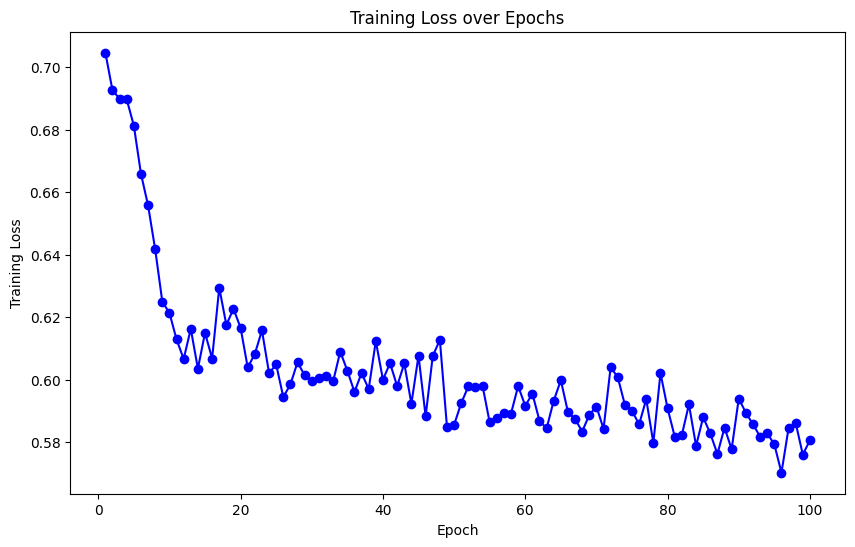

In [31]:
node_input_dim = 3
hidden_dim = 512
output_dim = 1

model = ReactionGNN(node_input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)  

criterion = nn.BCEWithLogitsLoss()

num_epochs = 100
epoch_losses = []  

for epoch in range(num_epochs):
    model.train()  
    total_loss = 0

    for ditopic_graph, tritopic_graph, label in train_loader:
        
        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        label = label.float()  

        optimizer.zero_grad()

        out = model(ditopic_graph, tritopic_graph).squeeze()  
        loss = criterion(out, label)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss) 

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(False)
plt.show()


In [33]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for ditopic_graph, tritopic_graph, label in test_loader:  
       
        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        label = label

        out = model(ditopic_graph, tritopic_graph)

        # Apply sigmoid to get probabilities and round to get predicted labels (0 or 1)
        probs = torch.sigmoid(out)
        preds = probs.round()  # Apply rounding to get binary predictions (0 or 1)

        preds = preds.cpu()
        label = label.cpu()

        for i in range(len(preds)):
            print(f"Sample {i+1}: Predicted Label = {int(preds[i].item())}, Actual Label = {int(label[i].item())}")

        correct += (preds.squeeze() == label).sum().item()
        total += label.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f} %')


Sample 1: Predicted Label = 1, Actual Label = 0
Sample 2: Predicted Label = 1, Actual Label = 0
Sample 3: Predicted Label = 0, Actual Label = 1
Sample 4: Predicted Label = 0, Actual Label = 1
Sample 5: Predicted Label = 1, Actual Label = 1
Sample 6: Predicted Label = 0, Actual Label = 1
Sample 7: Predicted Label = 1, Actual Label = 1
Sample 8: Predicted Label = 0, Actual Label = 1
Sample 9: Predicted Label = 1, Actual Label = 1
Sample 10: Predicted Label = 0, Actual Label = 0
Sample 11: Predicted Label = 0, Actual Label = 0
Sample 12: Predicted Label = 0, Actual Label = 0
Sample 13: Predicted Label = 0, Actual Label = 0
Sample 14: Predicted Label = 0, Actual Label = 1
Sample 15: Predicted Label = 0, Actual Label = 0
Sample 16: Predicted Label = 0, Actual Label = 0
Sample 17: Predicted Label = 0, Actual Label = 1
Sample 18: Predicted Label = 0, Actual Label = 0
Sample 19: Predicted Label = 0, Actual Label = 0
Sample 20: Predicted Label = 1, Actual Label = 1
Sample 21: Predicted Label = 

# Features as 1D tensors

### Both molecules has access to gloabal features

In [113]:
data_list = []

for index, row in data_reduced.iterrows():
    try:
  
        ditopic_graph = smiles_to_graph(row['di_smiles']) # Conversion to graphs
        tritopic_graph = smiles_to_graph(row['tri_smiles'])

        if ditopic_graph is None or tritopic_graph is None:
            print(f"Error processing row {index}: Invalid SMILES")
            continue

        ditopic_features = torch.tensor([ # Extracting molecular features into a 1D tensor
            row['di_h_bond_acceptor_count'],
            row['di_h_bond_donor_count'],
            row['di_xlogp'],
            row['di_tpsa'],
            row['di_arom_group']
        ], dtype=torch.float)

        tritopic_features = torch.tensor([
            row['tri_h_bond_acceptor_count'],
            row['tri_h_bond_donor_count'],
            row['tri_xlogp'],
            row['tri_tpsa'],
            row['di_arom_group']
        ], dtype=torch.float)

        # Assign label
        label = torch.tensor(row['turbidity_binary'], dtype=torch.float)  # Change to float for BCEWithLogitsLoss

        # Append graphs and features to the list, each with its label
        data_list.append((ditopic_graph, tritopic_graph, ditopic_features, tritopic_features, label))

    except Exception as e:
        print(f"Error processing row {index}: {e}")


In [114]:
data_list

[(Data(x=[10, 3], edge_index=[2, 20]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor([2.0000, 0.0000, 0.6087, 0.0000, 1.0000]),
  tensor([6.0000, 3.0000, 0.1237, 0.7759, 1.0000]),
  tensor(0.)),
 (Data(x=[15, 3], edge_index=[2, 30]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor([3.0000, 1.0000, 0.8261, 0.3568, 1.0000]),
  tensor([6.0000, 3.0000, 0.1237, 0.7759, 1.0000]),
  tensor(0.)),
 (Data(x=[12, 3], edge_index=[2, 26]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor([4.0000, 0.0000, 0.7681, 0.9930, 2.0000]),
  tensor([6.0000, 3.0000, 0.1237, 0.7759, 2.0000]),
  tensor(0.)),
 (Data(x=[10, 3], edge_index=[2, 20]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor([2.0000, 0.0000, 0.5652, 0.0000, 1.0000]),
  tensor([6.0000, 3.0000, 0.1237, 0.7759, 1.0000]),
  tensor(0.)),
 (Data(x=[14, 3], edge_index=[2, 28]),
  Data(x=[9, 3], edge_index=[2, 18]),
  tensor([6.0000, 0.0000, 0.6087, 0.0000, 1.0000]),
  tensor([6.0000, 3.0000, 0.1237, 0.7759, 1.0000]),
  tensor(0.)),
 (Data(x=[16, 3], ed

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ReactionGNN(nn.Module):
    def __init__(self, node_input_dim, hidden_dim, output_dim, feature_dim):
        super(ReactionGNN, self).__init__()
        
        # Adding more GCN layers for first graph (ditopic_graph)
        self.conv1_a = GCNConv(node_input_dim, hidden_dim)
        self.conv2_a = GCNConv(hidden_dim, hidden_dim)
        self.conv3_a = GCNConv(hidden_dim, hidden_dim)  # Adding a third GCN layer

        # Adding more GCN layers for second graph (tritopic_graph)
        self.conv1_b = GCNConv(node_input_dim, hidden_dim)
        self.conv2_b = GCNConv(hidden_dim, hidden_dim)
        self.conv3_b = GCNConv(hidden_dim, hidden_dim)  # Adding a third GCN layer

        # Fully connected layer to process the molecular features
        self.fc_features = nn.Linear(feature_dim * 2, hidden_dim) # Connects features a and b and reduces it to dim_h

        # Adding more fully connected layers to combine graph representations and feature embedding
        self.fc1 = nn.Linear(hidden_dim * 3, hidden_dim) # Combines graphs a and b + features a and b
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)  # Added another fully connected layer
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        
        # Activation, Dropout, and Batch Normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, data_a, data_b, features_a, features_b):
        # Process first graph (ditopic_graph)
        x_a, edge_index_a, batch_a = data_a.x, data_a.edge_index, data_a.batch
        x_a = self.relu(self.conv1_a(x_a, edge_index_a))
        x_a = self.relu(self.conv2_a(x_a, edge_index_a))
        x_a = self.relu(self.conv3_a(x_a, edge_index_a))
        x_a = global_mean_pool(x_a, batch_a)  # Shape: [batch_size, hidden_dim]
        
        # Process second graph (tritopic_graph)
        x_b, edge_index_b, batch_b = data_b.x, data_b.edge_index, data_b.batch
        x_b = self.relu(self.conv1_b(x_b, edge_index_b))
        x_b = self.relu(self.conv2_b(x_b, edge_index_b))
        x_b = self.relu(self.conv3_b(x_b, edge_index_b))
        x_b = global_mean_pool(x_b, batch_b)  # Shape: [batch_size, hidden_dim]
        
        # Process additional molecular features
        combined_features = torch.cat([features_a, features_b], dim=1)  # Shape: [batch_size, feature_dim * 2] combining everything
        feature_embedding = self.relu(self.fc_features(combined_features))  # Shape: [batch_size, hidden_dim]

    
        combined = torch.cat([x_a, x_b, feature_embedding], dim=1)  # Shape: [batch_size, hidden_dim * 3]
        
        x = self.relu(self.fc1(combined))  
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  
        x = self.batch_norm2(x)
        x = self.dropout(x)
        out = self.fc3(x) 

        return out


### For one test

In [21]:
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

train_dataset = ReactionDataset(train_data)
test_dataset = ReactionDataset(test_data)

In [22]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
node_input_dim = 3
hidden_dim = 512
output_dim = 1
feature_dim = 5 

In [29]:
model = ReactionGNN(node_input_dim, hidden_dim, output_dim, feature_dim)

optimizer = optim.Adagrad(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for ditopic_graph, tritopic_graph, ditopic_features, tritopic_features, label in train_loader:
        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        ditopic_features = ditopic_features
        tritopic_features = tritopic_features
        label = label.float()

        optimizer.zero_grad()

        out = model(ditopic_graph, tritopic_graph, ditopic_features, tritopic_features).squeeze()
        loss = criterion(out, label)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

num_epochs = len(epoch_losses)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(False)
plt.show()


ValueError: not enough values to unpack (expected 5, got 3)

In [46]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for ditopic_graph, tritopic_graph, ditopic_features, tritopic_features, label in test_loader:  

        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        ditopic_features = ditopic_features
        tritopic_features = tritopic_features
        label = label

        out = model(ditopic_graph, tritopic_graph, ditopic_features, tritopic_features)

        probs = torch.sigmoid(out)
        preds = probs.round()  


        preds = preds.cpu()
        label = label.cpu()

        for i in range(len(preds)):
            print(f"Sample {i + 1}: Predicted Label = {int(preds[i].item())}, Actual Label = {int(label[i].item())}")

        correct += (preds.squeeze() == label).sum().item()
        total += label.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f} %')


Sample 1: Predicted Label = 1, Actual Label = 0
Sample 2: Predicted Label = 0, Actual Label = 0
Sample 3: Predicted Label = 1, Actual Label = 1
Sample 4: Predicted Label = 1, Actual Label = 1
Sample 5: Predicted Label = 1, Actual Label = 1
Sample 6: Predicted Label = 1, Actual Label = 1
Sample 7: Predicted Label = 1, Actual Label = 1
Sample 8: Predicted Label = 0, Actual Label = 1
Sample 9: Predicted Label = 1, Actual Label = 1
Sample 10: Predicted Label = 0, Actual Label = 0
Sample 11: Predicted Label = 0, Actual Label = 0
Sample 12: Predicted Label = 0, Actual Label = 0
Sample 13: Predicted Label = 1, Actual Label = 0
Sample 14: Predicted Label = 1, Actual Label = 1
Sample 15: Predicted Label = 0, Actual Label = 0
Sample 16: Predicted Label = 0, Actual Label = 0
Sample 17: Predicted Label = 0, Actual Label = 1
Sample 18: Predicted Label = 0, Actual Label = 0
Sample 19: Predicted Label = 0, Actual Label = 0
Sample 20: Predicted Label = 1, Actual Label = 1
Sample 21: Predicted Label = 

### FOr multiple tests

In [30]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 100
num_experiments = 3  
accuracy_every_n_epochs = 10  


all_epoch_losses = []
all_epoch_accuracies = []  

for experiment in range(num_experiments):
    print(f"Starting experiment {experiment + 1}/{num_experiments}")

 
    model = ReactionGNN(node_input_dim, hidden_dim, output_dim, feature_dim)
    optimizer = optim.Adagrad(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

 
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0


        for ditopic_graph, tritopic_graph, ditopic_features, tritopic_features, label in train_loader:
       
            ditopic_graph = ditopic_graph
            tritopic_graph = tritopic_graph
            ditopic_features = ditopic_features
            tritopic_features = tritopic_features
            label = label.float()

            optimizer.zero_grad()

            out = model(ditopic_graph, tritopic_graph, ditopic_features, tritopic_features).squeeze()
            loss = criterion(out, label)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f'Experiment {experiment + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

        if (epoch + 1) % accuracy_every_n_epochs == 0:
            model.eval()
            correct = 0
            total = 0
            predicted_turbid = 0  
            predicted_dissolved = 0  

            with torch.no_grad():
                for ditopic_graph, tritopic_graph, ditopic_features, tritopic_features, label in test_loader:
                    out = model(ditopic_graph, tritopic_graph, ditopic_features, tritopic_features)

                    probs = torch.sigmoid(out)
                    preds = probs.round() 

       
                    correct += (preds.squeeze() == label).sum().item()
                    total += label.size(0)

  
                    predicted_turbid += (preds == 1).sum().item()
                    predicted_dissolved += (preds == 0).sum().item()

        
            accuracy = 100 * correct / total
            epoch_accuracies.append(accuracy)
            print(f'Experiment {experiment + 1}, Accuracy after Epoch {epoch + 1}: {accuracy:.2f} %')
            print(f'Predicted Turbid (1): {predicted_turbid}, Predicted Dissolved (0): {predicted_dissolved}')

    all_epoch_losses.append(epoch_losses)
    all_epoch_accuracies.append(epoch_accuracies)


all_epoch_losses = np.array(all_epoch_losses)
all_epoch_accuracies = np.array(all_epoch_accuracies)

mean_accuracies = np.nanmean(all_epoch_accuracies, axis=0)
std_accuracies = np.nanstd(all_epoch_accuracies, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

mean_losses = np.mean(all_epoch_losses, axis=0)
ax1.plot(range(1, num_epochs + 1), mean_losses, marker='o', color='b', label="Training Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(False)

epochs_with_accuracy = range(accuracy_every_n_epochs, num_epochs + 1, accuracy_every_n_epochs)

mean_accuracies = np.nanmean(all_epoch_accuracies, axis=0)
std_accuracies = np.nanstd(all_epoch_accuracies, axis=0)

ax2.errorbar(
    epochs_with_accuracy,
    mean_accuracies,
    yerr=std_accuracies,
    fmt='-o',
    ecolor='g',         
    capsize=5,           
    capthick=2,          
    label="Test Accuracy"
)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy over Epochs (mean ± std dev)')
ax2.grid(False)

plt.tight_layout()
plt.show()

Starting experiment 1/3


ValueError: not enough values to unpack (expected 5, got 3)

In [ ]:
df_explainability = turbidity_wo_triq_filtered.copy()

# Node feature augmentations

### This approach consist of node augmentation

In [31]:
data_list = []

for index, row in data_reduced.iterrows():
    try:
        
        ditopic_graph = smiles_to_graph(row['di_smiles'])
        tritopic_graph = smiles_to_graph(row['tri_smiles'])

        if ditopic_graph is None or tritopic_graph is None:
            print(f"Error processing row {index}: Invalid SMILES")
            continue

        ditopic_features = torch.tensor([
            row['di_h_bond_acceptor_count'],
            row['di_h_bond_donor_count'],
            row['di_xlogp'],
            row['di_tpsa'],
            row['tri_arom_group']
        ], dtype=torch.float)

        tritopic_features = torch.tensor([
            row['tri_h_bond_acceptor_count'],
            row['tri_h_bond_donor_count'],
            row['tri_xlogp'],
            row['tri_tpsa'],
            row['tri_arom_group']
        ], dtype=torch.float)

        ditopic_graph.x = torch.cat(
            [ditopic_graph.x, ditopic_features.expand(ditopic_graph.x.size(0), -1)], dim=1
        )
        tritopic_graph.x = torch.cat(
            [tritopic_graph.x, tritopic_features.expand(tritopic_graph.x.size(0), -1)], dim=1
        )

        label = torch.tensor(row['turbidity_binary'], dtype=torch.float)

        data_list.append((ditopic_graph, tritopic_graph, label))

    except Exception as e:
        print(f"Error processing row {index}: {e}")


NameError: name 'data_reduced' is not defined

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ReactionGNN(nn.Module):
    def __init__(self, node_input_dim, hidden_dim, output_dim, num_global_features):
        super(ReactionGNN, self).__init__()
        
        updated_node_input_dim = node_input_dim + num_global_features

        self.conv1_a = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_a = GCNConv(hidden_dim, hidden_dim)
        self.conv3_a = GCNConv(hidden_dim, hidden_dim)  

  
        self.conv1_b = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_b = GCNConv(hidden_dim, hidden_dim)
        self.conv3_b = GCNConv(hidden_dim, hidden_dim)  


        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2) 
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        
     
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, data_a, data_b):

        x_a, edge_index_a, batch_a = data_a.x, data_a.edge_index, data_a.batch
        x_a = self.relu(self.conv1_a(x_a, edge_index_a))  
        x_a = self.relu(self.conv2_a(x_a, edge_index_a))  
        x_a = self.relu(self.conv3_a(x_a, edge_index_a))  
        x_a = global_mean_pool(x_a, batch_a)  

  
        x_b, edge_index_b, batch_b = data_b.x, data_b.edge_index, data_b.batch
        x_b = self.relu(self.conv1_b(x_b, edge_index_b)) 
        x_b = self.relu(self.conv2_b(x_b, edge_index_b))  
        x_b = self.relu(self.conv3_b(x_b, edge_index_b))  
        x_b = global_mean_pool(x_b, batch_b)  

        
        combined = torch.cat([x_a, x_b], dim=1)  

        x = self.relu(self.fc1(combined)) 
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  
        x = self.batch_norm2(x)
        x = self.dropout(x)
        out = self.fc3(x) 

        return out


In [139]:
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

train_dataset = ReactionDataset(train_data)
test_dataset = ReactionDataset(test_data)


In [140]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [141]:
node_input_dim = 3
hidden_dim = 512
output_dim = 1
feature_dim = 5 
num_global_features = 5

### One test

Epoch 1/100, Loss: 0.7036
Epoch 2/100, Loss: 0.6003
Epoch 3/100, Loss: 0.5895
Epoch 4/100, Loss: 0.5763
Epoch 5/100, Loss: 0.6021
Epoch 6/100, Loss: 0.5479
Epoch 7/100, Loss: 0.5622
Epoch 8/100, Loss: 0.5382
Epoch 9/100, Loss: 0.5015
Epoch 10/100, Loss: 0.5200
Epoch 11/100, Loss: 0.5269
Epoch 12/100, Loss: 0.5028
Epoch 13/100, Loss: 0.5248
Epoch 14/100, Loss: 0.5302
Epoch 15/100, Loss: 0.4855
Epoch 16/100, Loss: 0.4968
Epoch 17/100, Loss: 0.4920
Epoch 18/100, Loss: 0.5207
Epoch 19/100, Loss: 0.4679
Epoch 20/100, Loss: 0.4899
Epoch 21/100, Loss: 0.4762
Epoch 22/100, Loss: 0.4690
Epoch 23/100, Loss: 0.4829
Epoch 24/100, Loss: 0.4620
Epoch 25/100, Loss: 0.4624
Epoch 26/100, Loss: 0.4860
Epoch 27/100, Loss: 0.4766
Epoch 28/100, Loss: 0.4515
Epoch 29/100, Loss: 0.4699
Epoch 30/100, Loss: 0.4711
Epoch 31/100, Loss: 0.4577
Epoch 32/100, Loss: 0.4707
Epoch 33/100, Loss: 0.4573
Epoch 34/100, Loss: 0.4478
Epoch 35/100, Loss: 0.4663
Epoch 36/100, Loss: 0.4463
Epoch 37/100, Loss: 0.4429
Epoch 38/1

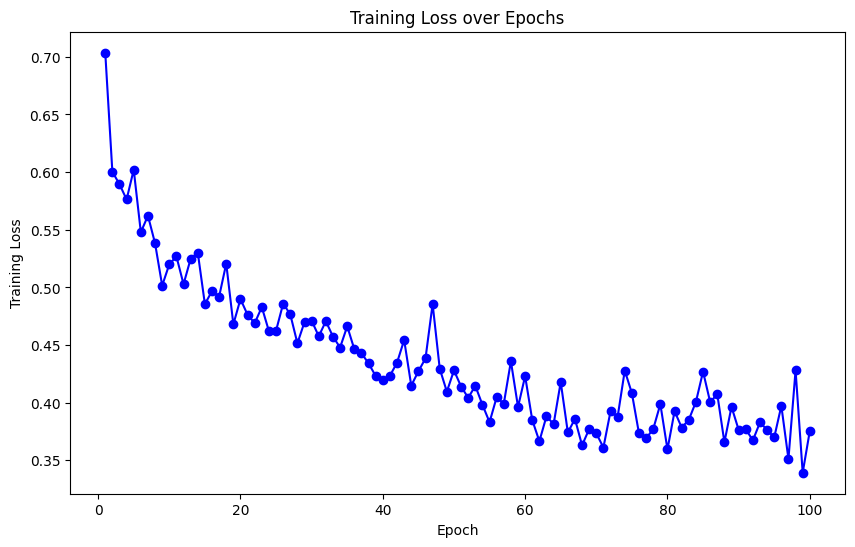

In [53]:
import torch.optim as optim
import matplotlib.pyplot as plt

model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.BCEWithLogitsLoss()

epoch_losses = []

num_epochs = 100

for epoch in range(num_epochs):
    model.train() 
    total_loss = 0

    for ditopic_graph, tritopic_graph, label in train_loader:
     
        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        label = label.float()  

        optimizer.zero_grad()

        out = model(ditopic_graph, tritopic_graph).squeeze()  
        loss = criterion(out, label) 

   
        loss.backward()
        optimizer.step()


        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)  


    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(False)
plt.show()


In [56]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for ditopic_graph, tritopic_graph, label in test_loader:  
x        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        label = label

        out = model(ditopic_graph, tritopic_graph)

        probs = torch.sigmoid(out)
        preds = probs.round()  
      
        preds = preds.cpu()
        label = label.cpu()

        for i in range(len(preds)):
            print(f"Sample {i + 1}: Predicted Label = {int(preds[i].item())}, Actual Label = {int(label[i].item())}")

        correct += (preds.squeeze() == label).sum().item()
        total += label.size(0)
        
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f} %')


Sample 1: Predicted Label = 1, Actual Label = 0
Sample 2: Predicted Label = 0, Actual Label = 0
Sample 3: Predicted Label = 1, Actual Label = 1
Sample 4: Predicted Label = 1, Actual Label = 1
Sample 5: Predicted Label = 1, Actual Label = 1
Sample 6: Predicted Label = 1, Actual Label = 1
Sample 7: Predicted Label = 1, Actual Label = 1
Sample 8: Predicted Label = 0, Actual Label = 1
Sample 9: Predicted Label = 1, Actual Label = 1
Sample 10: Predicted Label = 1, Actual Label = 0
Sample 11: Predicted Label = 0, Actual Label = 0
Sample 12: Predicted Label = 0, Actual Label = 0
Sample 13: Predicted Label = 1, Actual Label = 0
Sample 14: Predicted Label = 1, Actual Label = 1
Sample 15: Predicted Label = 0, Actual Label = 0
Sample 16: Predicted Label = 0, Actual Label = 0
Sample 17: Predicted Label = 1, Actual Label = 1
Sample 18: Predicted Label = 0, Actual Label = 0
Sample 19: Predicted Label = 0, Actual Label = 0
Sample 20: Predicted Label = 1, Actual Label = 1
Sample 21: Predicted Label = 

### Multiple tests

Starting experiment 1/3
Experiment 1, Epoch 1/100, Loss: 0.6838
Experiment 1, Epoch 2/100, Loss: 0.6087
Experiment 1, Epoch 3/100, Loss: 0.5790
Experiment 1, Epoch 4/100, Loss: 0.5644
Experiment 1, Epoch 5/100, Loss: 0.5706
Experiment 1, Epoch 6/100, Loss: 0.5456
Experiment 1, Epoch 7/100, Loss: 0.5375
Experiment 1, Epoch 8/100, Loss: 0.5422
Experiment 1, Epoch 9/100, Loss: 0.5398
Experiment 1, Epoch 10/100, Loss: 0.5318
Experiment 1, Accuracy after Epoch 10: 64.29 %
Predicted Turbid (1): 24, Predicted Dissolved (0): 46
Experiment 1, Epoch 11/100, Loss: 0.5379
Experiment 1, Epoch 12/100, Loss: 0.5287
Experiment 1, Epoch 13/100, Loss: 0.5277
Experiment 1, Epoch 14/100, Loss: 0.5220
Experiment 1, Epoch 15/100, Loss: 0.5250
Experiment 1, Epoch 16/100, Loss: 0.5069
Experiment 1, Epoch 17/100, Loss: 0.5206
Experiment 1, Epoch 18/100, Loss: 0.5203
Experiment 1, Epoch 19/100, Loss: 0.4880
Experiment 1, Epoch 20/100, Loss: 0.4984
Experiment 1, Accuracy after Epoch 20: 67.14 %
Predicted Turbid 

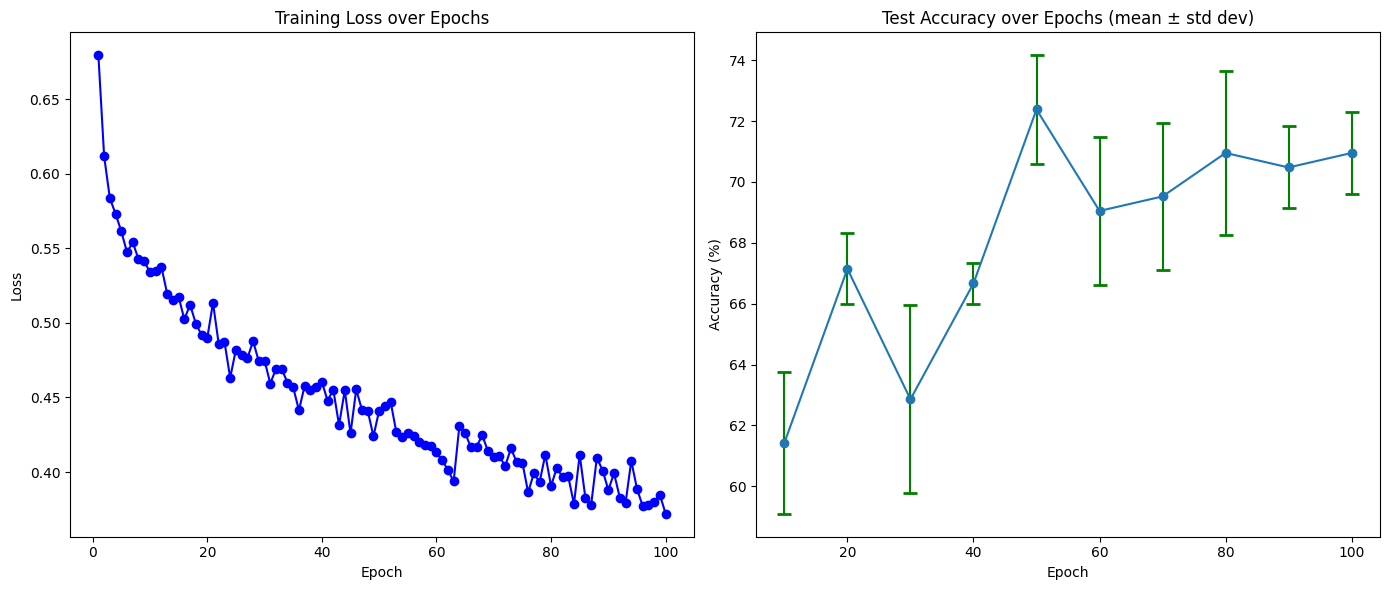

In [142]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader, num_epochs=100, num_experiments=3, accuracy_every_n_epochs=10):
    all_epoch_losses = []
    all_epoch_accuracies = []  

    for experiment in range(num_experiments):
        print(f"Starting experiment {experiment + 1}/{num_experiments}")

       
        model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features)
        optimizer = optim.Adagrad(model.parameters(), lr=0.001)
        criterion = nn.BCEWithLogitsLoss()

        epoch_losses = []
        epoch_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

           
            for ditopic_graph, tritopic_graph, label in train_loader:
                
                label = label.float()

                optimizer.zero_grad()

            
                out = model(ditopic_graph, tritopic_graph).squeeze()
                loss = criterion(out, label)


                loss.backward()
                optimizer.step()

          
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            epoch_losses.append(avg_loss)
            print(f'Experiment {experiment + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

       
            if (epoch + 1) % accuracy_every_n_epochs == 0:
                model.eval()
                correct = 0
                total = 0
                predicted_turbid = 0  
                predicted_dissolved = 0  

                with torch.no_grad():
                    for ditopic_graph, tritopic_graph, label in test_loader:
       
                        out = model(ditopic_graph, tritopic_graph)

                        
                        probs = torch.sigmoid(out)
                        preds = probs.round()  

                        correct += (preds.squeeze() == label).sum().item()
                        total += label.size(0)

                        predicted_turbid += (preds == 1).sum().item()
                        predicted_dissolved += (preds == 0).sum().item()

                accuracy = 100 * correct / total
                epoch_accuracies.append(accuracy)
                print(f'Experiment {experiment + 1}, Accuracy after Epoch {epoch + 1}: {accuracy:.2f} %')
                print(f'Predicted Turbid (1): {predicted_turbid}, Predicted Dissolved (0): {predicted_dissolved}')

        all_epoch_losses.append(epoch_losses)
        all_epoch_accuracies.append(epoch_accuracies)

    all_epoch_losses = np.array(all_epoch_losses)
    all_epoch_accuracies = np.array(all_epoch_accuracies)


    mean_accuracies = np.nanmean(all_epoch_accuracies, axis=0)
    std_accuracies = np.nanstd(all_epoch_accuracies, axis=0)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


    mean_losses = np.mean(all_epoch_losses, axis=0)
    ax1.plot(range(1, num_epochs + 1), mean_losses, marker='o', color='b', label="Training Loss")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss over Epochs')
    ax1.grid(False)


    epochs_with_accuracy = range(accuracy_every_n_epochs, num_epochs + 1, accuracy_every_n_epochs)

    mean_accuracies = np.nanmean(all_epoch_accuracies, axis=0)
    std_accuracies = np.nanstd(all_epoch_accuracies, axis=0)


    ax2.errorbar(
        epochs_with_accuracy,
        mean_accuracies,
        yerr=std_accuracies,
        fmt='-o',
        ecolor='g',         
        capsize=5,           
        capthick=2,        
        label="Test Accuracy"
    )
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Test Accuracy over Epochs (mean ± std dev)')
    ax2.grid(False)

    plt.tight_layout()
    plt.show()

train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader)


# All features

In [143]:
data_all = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/all_dataset_turbidity.csv')

In [144]:
data_all.columns

Index(['Unnamed: 0', 'di_name', 'tri_name', 'di_smiles', 'tri_smiles',
       'turbidity_label', 'turbidity', 'turbidity_binary', 'di_charge',
       'di_complexity', 'di_covalent_unit_count',
       'di_defined_atom_stereo_count', 'di_defined_bond_stereo_count',
       'di_exact_mass', 'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_heavy_atom_count', 'di_xlogp', 'di_molecular_weight',
       'di_rotatable_bond_count', 'di_tpsa', 'tri_charge', 'tri_complexity',
       'tri_covalent_unit_count', 'tri_defined_atom_stereo_count',
       'tri_defined_bond_stereo_count', 'tri_exact_mass',
       'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
       'tri_heavy_atom_count', 'tri_xlogp', 'tri_molecular_weight',
       'tri_rotatable_bond_count', 'tri_tpsa', 'di_arom_group',
       'tri_arom_group'],
      dtype='object')

In [145]:
def load_and_filter_df_selected(df):
    
    required_columns = [
    
    'turbidity_binary', 'di_smiles', 'tri_smiles', 'di_charge', 'di_complexity',
    'di_covalent_unit_count', 'di_defined_atom_stereo_count',
    'di_defined_bond_stereo_count', 'di_exact_mass',
    'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
    'di_heavy_atom_count', 'di_xlogp', 'di_molecular_weight',
    'di_rotatable_bond_count', 'di_tpsa', 'tri_charge', 'tri_complexity',
    'tri_covalent_unit_count', 'tri_defined_atom_stereo_count',
    'tri_defined_bond_stereo_count', 'tri_exact_mass',
    'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
    'tri_heavy_atom_count', 'tri_xlogp', 'tri_molecular_weight',
    'tri_rotatable_bond_count', 'tri_tpsa', 'di_arom_group', 'tri_arom_group'
    
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    
    filtered_df = df[available_columns]

    filtered_df.fillna('unknown', inplace=True)

    return filtered_df


In [146]:
data_all = load_and_filter_df_selected(data_all)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_25807/1195587888.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)


In [147]:
data_all

,turbidity_binary,di_smiles,tri_smiles,di_charge,di_complexity,di_covalent_unit_count,di_defined_atom_stereo_count,di_defined_bond_stereo_count,di_exact_mass,di_h_bond_acceptor_count,...,tri_exact_mass,tri_h_bond_acceptor_count,tri_h_bond_donor_count,tri_heavy_atom_count,tri_xlogp,tri_molecular_weight,tri_rotatable_bond_count,tri_tpsa,di_arom_group,tri_arom_group
0,0,O=Cc1cccc(C=O)c1,Nc1nc(N)nc(N)n1,0,117.0,1,0,0,134.036779,2,...,126.065394,6.0,3.0,9.0,-1.4,126.12,0.0,117.0,1,1
1,0,CC(C)(C)c1cc(C=O)c(O)c(C=O)c1,Nc1nc(N)nc(N)n1,0,224.0,1,0,0,206.094294,3,...,126.065394,6.0,3.0,9.0,-1.4,126.12,0.0,117.0,1,1
2,0,O=Cc1cc2sc(C=O)cc2s1,Nc1nc(N)nc(N)n1,0,185.0,1,0,0,195.965272,4,...,126.065394,6.0,3.0,9.0,-1.4,126.12,0.0,117.0,2,1
3,0,O=Cc1ccc(C=O)cc1,Nc1nc(N)nc(N)n1,0,107.0,1,0,0,134.036779,2,...,126.065394,6.0,3.0,9.0,-1.4,126.12,0.0,117.0,1,1
4,0,O=Cc1c(F)c(F)c(C=O)c(F)c1F,Nc1nc(N)nc(N)n1,0,195.0,1,0,0,205.999092,6,...,126.065394,6.0,3.0,9.0,-1.4,126.12,0.0,117.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1,NCCOCCN,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,0,28.9,1,0,0,104.094963,3,...,468.172545,3.0,0.0,36.0,7.1,468.50,9.0,51.2,0,4
344,1,NCC1=CC(CN)=CC=C1,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,0,83.3,1,0,0,136.100048,2,...,468.172545,3.0,0.0,36.0,7.1,468.50,9.0,51.2,1,4
345,1,NCC(CN)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,0,28.0,1,0,0,90.079313,3,...,468.172545,3.0,0.0,36.0,7.1,468.50,9.0,51.2,0,4
346,1,NCCCC[C@H](N)C(=O)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,0,106.0,1,1,0,146.105528,4,...,468.172545,3.0,0.0,36.0,7.1,468.50,9.0,51.2,0,4


### Min-max standardization

In [148]:
exclude_columns = ['turbidity_binary', 'di_smiles', 'di_h_bond_acceptor_count', 'tri_h_bond_acceptor_count', 'di_h_bond_donor_count', 'tri_smiles','tri_h_bond_donor_count', 'di_arom_group',	'tri_arom_group']  

data_to_normalize = data_all.drop(columns=exclude_columns)
data_excluded = data_all[exclude_columns]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_df = pd.DataFrame(normalized_data, columns=data_to_normalize.columns)

final_df = pd.concat([normalized_df, data_excluded], axis=1)

final_df = final_df[data_all.columns]

normalized_df = pd.DataFrame(final_df)

In [150]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum(), int(atom.GetDegree()), int(atom.GetIsAromatic())])
    
    atom_features = torch.tensor(atom_features, dtype=torch.float)
    
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append([i, j])
        edges.append([j, i])  
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  
    
    data = Data(x=atom_features, edge_index=edge_index)
    return data


In [151]:
from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None  
    except Exception as e:
        print(f"Error validating SMILES {smiles}: {e}")
        return False


In [152]:
normalized_df['di_smiles_valid'] = normalized_df['di_smiles'].apply(is_valid_smiles)
normalized_df['tri_smiles_valid'] = normalized_df['tri_smiles'].apply(is_valid_smiles)

valid_rows = normalized_df[normalized_df['di_smiles_valid'] & normalized_df['tri_smiles_valid']]
invalid_rows = normalized_df[~(normalized_df['di_smiles_valid'] & normalized_df['tri_smiles_valid'])]
print(f"Invalid SMILES entries:\n{invalid_rows[['di_smiles', 'tri_smiles']]}")

Invalid SMILES entries:
Empty DataFrame
Columns: [di_smiles, tri_smiles]
Index: []


# Node features augmentation

In [153]:
data_list = []

for index, row in normalized_df.iterrows():
    try:
        ditopic_graph = smiles_to_graph(row['di_smiles'])
        tritopic_graph = smiles_to_graph(row['tri_smiles'])

 
        if ditopic_graph is None or tritopic_graph is None:
            print(f"Error processing row {index}: Invalid SMILES")
            continue

        if ditopic_graph.x is None or tritopic_graph.x is None:
            print(f"Error processing row {index}: Graph returned without node features")
            continue


        ditopic_features = torch.tensor([
            row['di_h_bond_acceptor_count'],
            row['di_h_bond_donor_count'],
            row['di_xlogp'],
            row['di_tpsa'],
            row['di_arom_group'],
            row['di_charge'],
            row['di_complexity'],
            row['di_covalent_unit_count'],
            row['di_defined_atom_stereo_count'],
            row['di_defined_bond_stereo_count'],
            row['di_exact_mass'],
            row['di_heavy_atom_count'],
            row['di_molecular_weight'],
            row['di_rotatable_bond_count']
        ], dtype=torch.float)

        tritopic_features = torch.tensor([
            row['tri_h_bond_acceptor_count'],
            row['tri_h_bond_donor_count'],
            row['tri_xlogp'],
            row['tri_tpsa'],
            row['tri_arom_group'],
            row['tri_charge'],
            row['tri_complexity'],
            row['tri_covalent_unit_count'],
            row['tri_defined_atom_stereo_count'],
            row['tri_defined_bond_stereo_count'],
            row['tri_exact_mass'],
            row['tri_heavy_atom_count'],
            row['tri_molecular_weight'],
            row['tri_rotatable_bond_count']
        ], dtype=torch.float)


        print(f"Row {index}: ditopic_graph.x shape before augmentation: {ditopic_graph.x.shape}")
        print(f"ditopic_features shape: {ditopic_features.shape}")

  
        ditopic_graph.x = torch.cat(
            [ditopic_graph.x, ditopic_features.expand(ditopic_graph.x.size(0), -1)], dim=1
        )
        tritopic_graph.x = torch.cat(
            [tritopic_graph.x, tritopic_features.expand(tritopic_graph.x.size(0), -1)], dim=1
        )

        label = torch.tensor(row['turbidity_binary'], dtype=torch.float)

        
        data_list.append((ditopic_graph, tritopic_graph, label))

    except KeyError as e:
        print(f"KeyError processing row {index}: {e}")
    except ValueError as e:
        print(f"ValueError processing row {index}: {e}")
    except Exception as e:
        print(f"Error processing row {index}: {e}")


Row 0: ditopic_graph.x shape before augmentation: torch.Size([10, 3])
ditopic_features shape: torch.Size([14])
Row 1: ditopic_graph.x shape before augmentation: torch.Size([15, 3])
ditopic_features shape: torch.Size([14])
Row 2: ditopic_graph.x shape before augmentation: torch.Size([12, 3])
ditopic_features shape: torch.Size([14])
Row 3: ditopic_graph.x shape before augmentation: torch.Size([10, 3])
ditopic_features shape: torch.Size([14])
Row 4: ditopic_graph.x shape before augmentation: torch.Size([14, 3])
ditopic_features shape: torch.Size([14])
Row 5: ditopic_graph.x shape before augmentation: torch.Size([16, 3])
ditopic_features shape: torch.Size([14])
Row 6: ditopic_graph.x shape before augmentation: torch.Size([18, 3])
ditopic_features shape: torch.Size([14])
Row 7: ditopic_graph.x shape before augmentation: torch.Size([18, 3])
ditopic_features shape: torch.Size([14])
Row 8: ditopic_graph.x shape before augmentation: torch.Size([9, 3])
ditopic_features shape: torch.Size([14])
Ro

In [154]:
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

train_dataset = ReactionDataset(train_data)
test_dataset = ReactionDataset(test_data)


In [155]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ReactionGNN(nn.Module):
    def __init__(self, node_input_dim, hidden_dim, output_dim, num_global_features):
        super(ReactionGNN, self).__init__()
      
        updated_node_input_dim = node_input_dim 
 
        self.conv1_a = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_a = GCNConv(hidden_dim, hidden_dim)
        self.conv3_a = GCNConv(hidden_dim, hidden_dim)  


        self.conv1_b = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_b = GCNConv(hidden_dim, hidden_dim)
        self.conv3_b = GCNConv(hidden_dim, hidden_dim) 

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)


        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, data_a, data_b):
        # Process the first graph (ditopic_graph)
        x_a, edge_index_a, batch_a = data_a.x, data_a.edge_index, data_a.batch
        x_a = self.relu(self.conv1_a(x_a, edge_index_a))
        x_a = self.relu(self.conv2_a(x_a, edge_index_a))
        x_a = self.relu(self.conv3_a(x_a, edge_index_a))
        x_a = global_mean_pool(x_a, batch_a)

        #Debugging: Print the shape of x_a after pooling
        print(f"x_a shape after pooling: {x_a.shape}") 

        x_b, edge_index_b, batch_b = data_b.x, data_b.edge_index, data_b.batch
        x_b = self.relu(self.conv1_b(x_b, edge_index_b))
        x_b = self.relu(self.conv2_b(x_b, edge_index_b))
        x_b = self.relu(self.conv3_b(x_b, edge_index_b))
        x_b = global_mean_pool(x_b, batch_b)

        #Debugging: Print the shape of x_b after pooling
        print(f"x_b shape after pooling: {x_b.shape}") 

        combined = torch.cat([x_a, x_b], dim=1)  

        print(f"Combined shape: {combined.shape}") 

        x = self.relu(self.fc1(combined))  
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x)) 
        x = self.batch_norm2(x)
        x = self.dropout(x)
        out = self.fc3(x) 

        return out


In [160]:
node_input_dim = 17
hidden_dim = 512
output_dim = 1
feature_dim = 5 
num_global_features = 14

### For one test

x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after poolin

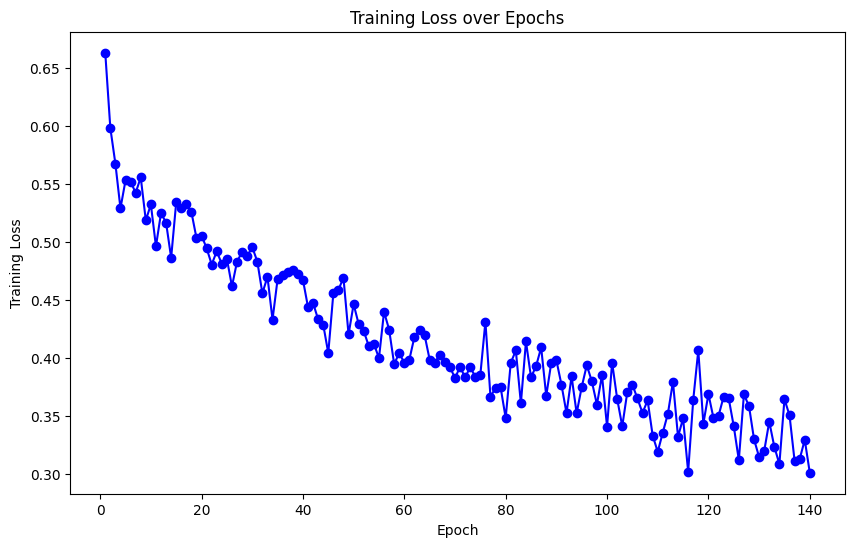

In [96]:
import torch.optim as optim
import matplotlib.pyplot as plt

model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.BCEWithLogitsLoss()

epoch_losses = []

num_epochs = 140

for epoch in range(num_epochs):
    model.train() 
    total_loss = 0

    for ditopic_graph, tritopic_graph, label in train_loader:
        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        label = label.float()  

        optimizer.zero_grad()

        out = model(ditopic_graph, tritopic_graph).squeeze()  
        loss = criterion(out, label) 

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

 
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)  

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(False)
plt.show()


In [98]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for ditopic_graph, tritopic_graph, label in test_loader:  
        ditopic_graph = ditopic_graph
        tritopic_graph = tritopic_graph
        label = label


        out = model(ditopic_graph, tritopic_graph)

   
        probs = torch.sigmoid(out)
        preds = probs.round()  

        preds = preds.cpu()
        label = label.cpu()

        for i in range(len(preds)):
            print(f"Sample {i + 1}: Predicted Label = {int(preds[i].item())}, Actual Label = {int(label[i].item())}")

        correct += (preds.squeeze() == label).sum().item()
        total += label.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f} %')


x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
Sample 1: Predicted Label = 0, Actual Label = 0
Sample 2: Predicted Label = 0, Actual Label = 0
Sample 3: Predicted Label = 1, Actual Label = 1
Sample 4: Predicted Label = 1, Actual Label = 1
Sample 5: Predicted Label = 0, Actual Label = 1
Sample 6: Predicted Label = 1, Actual Label = 1
Sample 7: Predicted Label = 0, Actual Label = 1
Sample 8: Predicted Label = 0, Actual Label = 1
Sample 9: Predicted Label = 1, Actual Label = 1
Sample 10: Predicted Label = 1, Actual Label = 0
Sample 11: Predicted Label = 0, Actual Label = 0
Sample 12: Predicted Label = 0, Actual Label = 0
Sample 13: Predicted Label = 1, Actual Label = 0
Sample 14: Predicted Label = 1, Actual Label = 1
Sample 15: Predicted Label = 0, Actual Label = 0
Sample 16: Predicted Label = 0, Actual Label = 0
Sample 17: Predicted Label = 1, Actual Label = 1
Sample 18: Predicted Label = 0, Actual Labe

### For multiple tests

Starting experiment 1/3
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512]

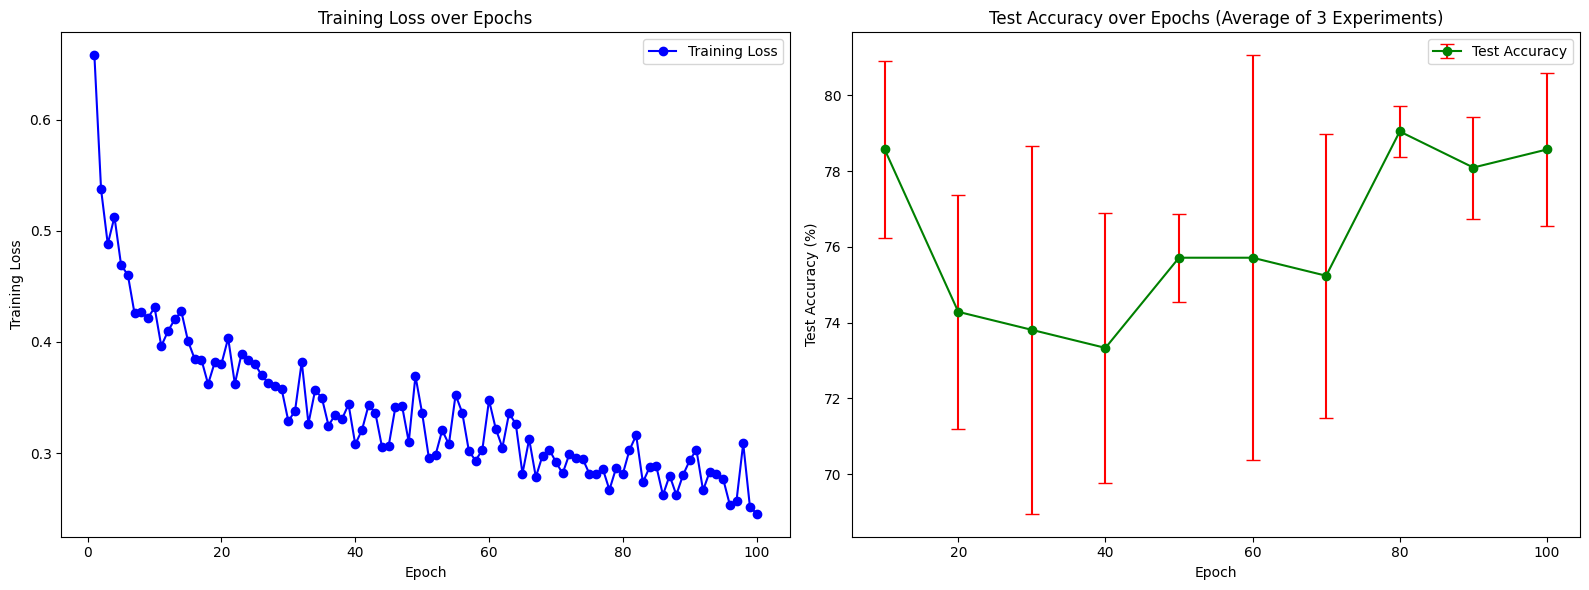

In [161]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader, num_epochs=100, num_experiments=3, accuracy_every_n_epochs=10):
    all_epoch_losses = []
    all_test_accuracies = []

    for experiment in range(num_experiments):
        print(f"Starting experiment {experiment + 1}/{num_experiments}")

        model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        criterion = nn.BCEWithLogitsLoss()

        epoch_losses = []  
        test_accuracies = []  

        for epoch in range(num_epochs):
            model.train() 
            total_loss = 0

            for ditopic_graph, tritopic_graph, label in train_loader:
                label = label.float()

                optimizer.zero_grad()

                out = model(ditopic_graph, tritopic_graph).squeeze()  
                loss = criterion(out, label)  

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
        
            avg_loss = total_loss / len(train_loader)
            epoch_losses.append(avg_loss)  

            print(f'Experiment {experiment + 1}, Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}')

            if (epoch + 1) % accuracy_every_n_epochs == 0:
                model.eval()  
                correct = 0
                total = 0

                with torch.no_grad():
                    for ditopic_graph, tritopic_graph, label in test_loader:  
                        out = model(ditopic_graph, tritopic_graph)

                        probs = torch.sigmoid(out)
                        preds = probs.round()  

                        preds = preds.cpu()
                        label = label.cpu()

                        correct += (preds.squeeze() == label).sum().item()
                        total += label.size(0)

                accuracy = 100 * correct / total
                test_accuracies.append(accuracy) 
                print(f'Experiment {experiment + 1}, Test Accuracy after Epoch {epoch + 1}: {accuracy:.2f} %')

        all_epoch_losses.append(epoch_losses)
        all_test_accuracies.append(test_accuracies)

    all_test_accuracies = np.array(all_test_accuracies)

    mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
    std_test_accuracies = np.std(all_test_accuracies, axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
 
    axes[0].plot(range(1, num_epochs + 1), all_epoch_losses[-1], marker='o', linestyle='-', color='b', label='Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title('Training Loss over Epochs')
    axes[0].legend()
    axes[0].grid(False)

    test_epochs = range(10, num_epochs + 1, 10)
    axes[1].errorbar(test_epochs, mean_test_accuracies, yerr=std_test_accuracies, fmt='-o', color='g', ecolor='r', capsize=5, label='Test Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Test Accuracy (%)')
    axes[1].set_title('Test Accuracy over Epochs (Average of 3 Experiments)')
    axes[1].legend()
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()

train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader)


Starting experiment 1/3
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512])
x_b shape after pooling: torch.Size([32, 512])
Combined shape: torch.Size([32, 1024])
x_a shape after pooling: torch.Size([32, 512]

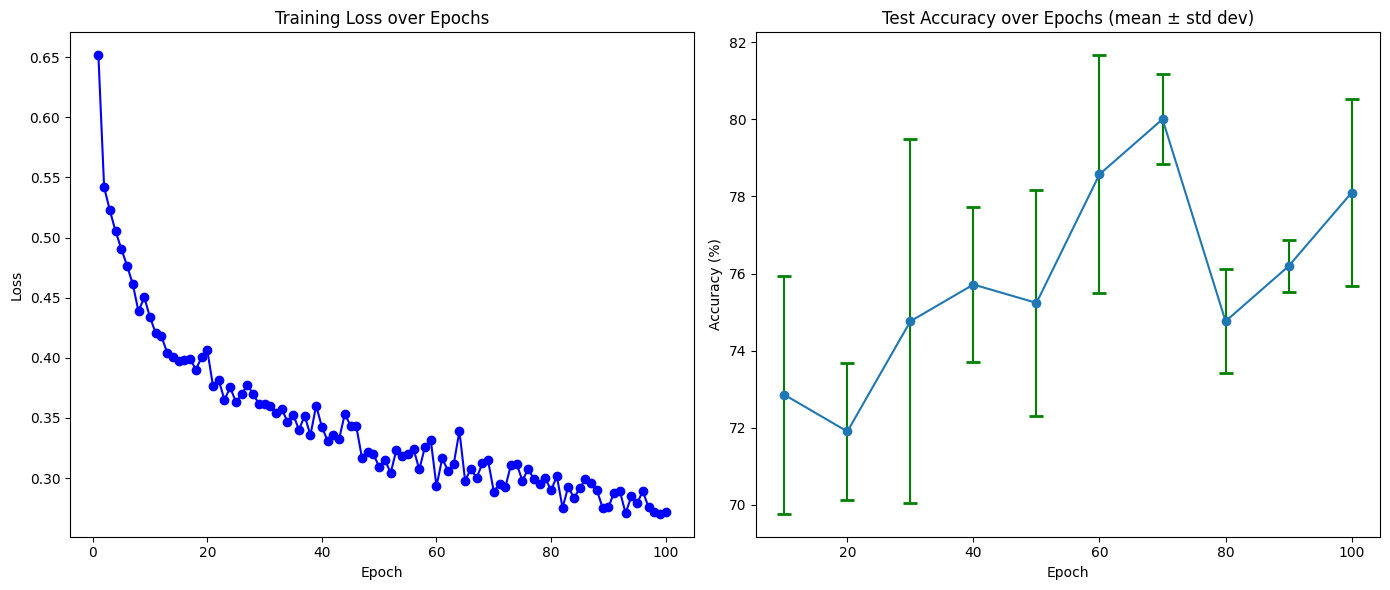

In [162]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader, num_epochs=100, num_experiments=3, accuracy_every_n_epochs=10):
    all_epoch_losses = []
    all_epoch_accuracies = [] 

    for experiment in range(num_experiments):
        print(f"Starting experiment {experiment + 1}/{num_experiments}")

        model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features)
        optimizer = optim.Adagrad(model.parameters(), lr=0.001)
        criterion = nn.BCEWithLogitsLoss()

        epoch_losses = []
        epoch_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for ditopic_graph, tritopic_graph, label in train_loader:
                label = label.float()

                optimizer.zero_grad()

                out = model(ditopic_graph, tritopic_graph).squeeze()
                loss = criterion(out, label)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            epoch_losses.append(avg_loss)
            print(f'Experiment {experiment + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

            if (epoch + 1) % accuracy_every_n_epochs == 0:
                model.eval()
                correct = 0
                total = 0
                predicted_turbid = 0  
                predicted_dissolved = 0  

                with torch.no_grad():
                    for ditopic_graph, tritopic_graph, label in test_loader:
                        
                        out = model(ditopic_graph, tritopic_graph)

                        probs = torch.sigmoid(out)
                        preds = probs.round()  

                        correct += (preds.squeeze() == label).sum().item()
                        total += label.size(0)

                        predicted_turbid += (preds == 1).sum().item()
                        predicted_dissolved += (preds == 0).sum().item()

                accuracy = 100 * correct / total
                epoch_accuracies.append(accuracy)
                print(f'Experiment {experiment + 1}, Accuracy after Epoch {epoch + 1}: {accuracy:.2f} %')
                print(f'Predicted Turbid (1): {predicted_turbid}, Predicted Dissolved (0): {predicted_dissolved}')

        all_epoch_losses.append(epoch_losses)
        all_epoch_accuracies.append(epoch_accuracies)

    all_epoch_losses = np.array(all_epoch_losses)
    all_epoch_accuracies = np.array(all_epoch_accuracies)

    mean_accuracies = np.nanmean(all_epoch_accuracies, axis=0)
    std_accuracies = np.nanstd(all_epoch_accuracies, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    mean_losses = np.mean(all_epoch_losses, axis=0)
    ax1.plot(range(1, num_epochs + 1), mean_losses, marker='o', color='b', label="Training Loss")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss over Epochs')
    ax1.grid(False)

    epochs_with_accuracy = range(accuracy_every_n_epochs, num_epochs + 1, accuracy_every_n_epochs)

    ax2.errorbar(
        epochs_with_accuracy,
        mean_accuracies,
        yerr=std_accuracies,
        fmt='-o',
        ecolor='g',         
        capsize=5,        
        capthick=2,        
        label="Test Accuracy"
    )
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Test Accuracy over Epochs (mean ± std dev)')
    ax2.grid(False)

    plt.tight_layout()
    plt.show()

train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader)


# Correlation study of features with  turbidity labels

The idea here will be to select the important features by correlation study

Correlation between each feature and the output label:
di_h_bond_acceptor_count        -0.096373
di_h_bond_donor_count            0.435521
di_xlogp                        -0.339592
di_tpsa                          0.141935
di_arom_group                   -0.377872
di_charge                             NaN
di_complexity                   -0.341109
di_covalent_unit_count                NaN
di_defined_atom_stereo_count    -0.079402
di_defined_bond_stereo_count          NaN
di_exact_mass                   -0.172857
di_heavy_atom_count             -0.190826
di_molecular_weight             -0.172933
di_rotatable_bond_count          0.226451
tri_h_bond_acceptor_count       -0.017546
tri_h_bond_donor_count          -0.336835
tri_xlogp                        0.299338
tri_tpsa                        -0.169721
tri_arom_group                   0.272890
tri_charge                            NaN
tri_complexity                   0.275423
tri_covalent_unit_count               NaN
tri_defined_atom_ster

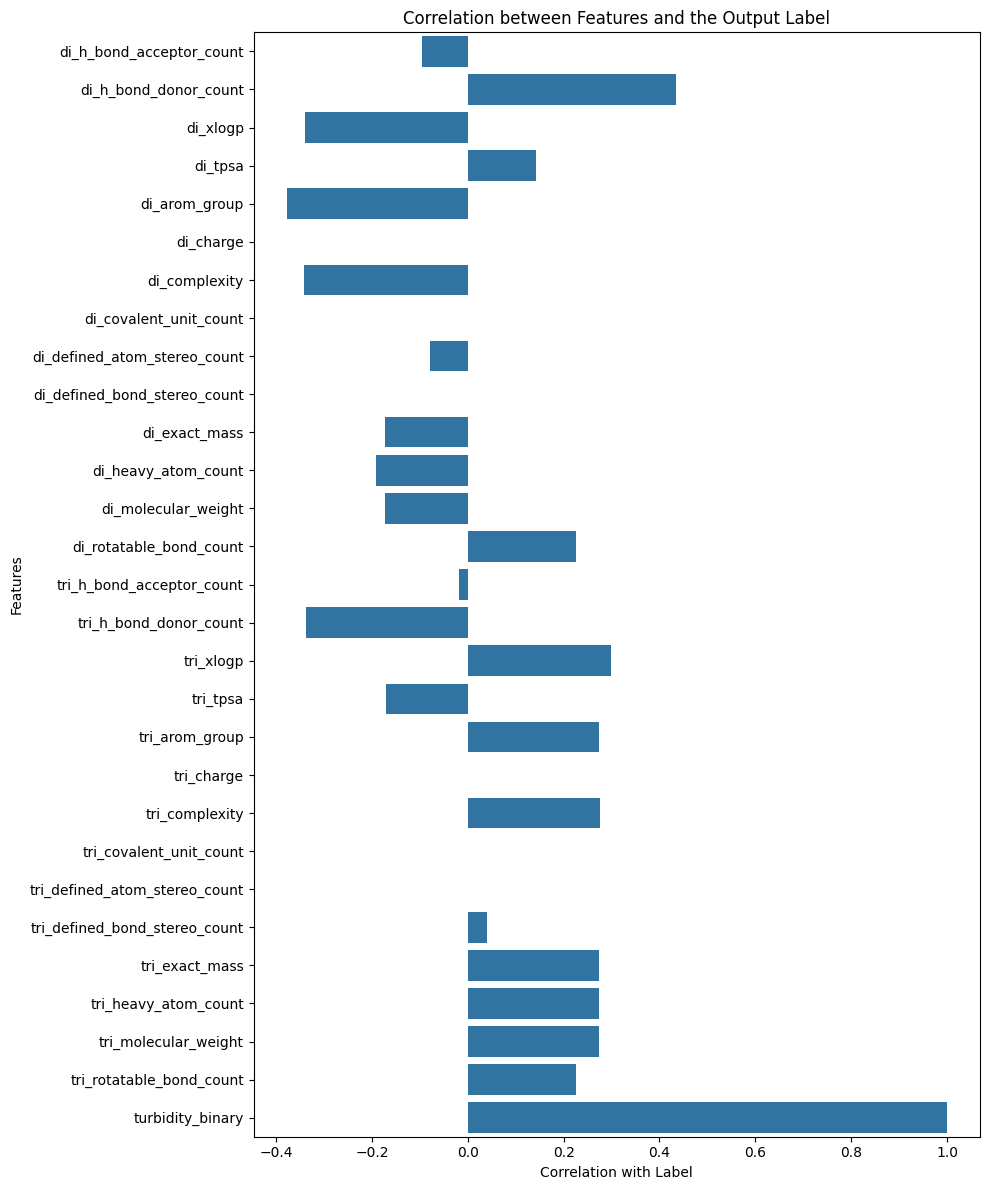

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


global_features = [
    'di_h_bond_acceptor_count', 'di_h_bond_donor_count', 'di_xlogp', 'di_tpsa', 'di_arom_group',
    'di_charge', 'di_complexity', 'di_covalent_unit_count', 'di_defined_atom_stereo_count',
    'di_defined_bond_stereo_count', 'di_exact_mass', 'di_heavy_atom_count', 'di_molecular_weight',
    'di_rotatable_bond_count', 'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
    'tri_xlogp', 'tri_tpsa', 'tri_arom_group', 'tri_charge', 'tri_complexity', 
    'tri_covalent_unit_count', 'tri_defined_atom_stereo_count', 'tri_defined_bond_stereo_count', 
    'tri_exact_mass', 'tri_heavy_atom_count', 'tri_molecular_weight', 'tri_rotatable_bond_count'
]

label = 'turbidity_binary'


df_for_correlation = normalized_df[global_features + [label]]

correlation_matrix = df_for_correlation.corr()

correlation_with_label = correlation_matrix[label]

print("Correlation between each feature and the output label:")
print(correlation_with_label)


plt.figure(figsize=(10, 12))  
sns.barplot(y=correlation_with_label.index, x=correlation_with_label.values, orient='h')
plt.ylabel('Features')
plt.xlabel('Correlation with Label')
plt.title('Correlation between Features and the Output Label')
plt.tight_layout()
plt.show()



Top 80% Most Correlated Features: ['turbidity_binary', 'di_h_bond_donor_count', 'di_arom_group', 'di_complexity', 'di_xlogp', 'tri_h_bond_donor_count', 'tri_xlogp', 'tri_complexity', 'tri_heavy_atom_count', 'tri_exact_mass', 'tri_molecular_weight', 'tri_arom_group', 'di_rotatable_bond_count', 'tri_rotatable_bond_count', 'di_heavy_atom_count', 'di_molecular_weight', 'di_exact_mass', 'tri_tpsa', 'di_tpsa', 'di_h_bond_acceptor_count', 'di_defined_atom_stereo_count', 'tri_defined_bond_stereo_count', 'tri_h_bond_acceptor_count']
Bottom 20% Least Correlated Features: ['di_charge', 'di_covalent_unit_count', 'di_defined_bond_stereo_count', 'tri_charge', 'tri_covalent_unit_count', 'tri_defined_atom_stereo_count']


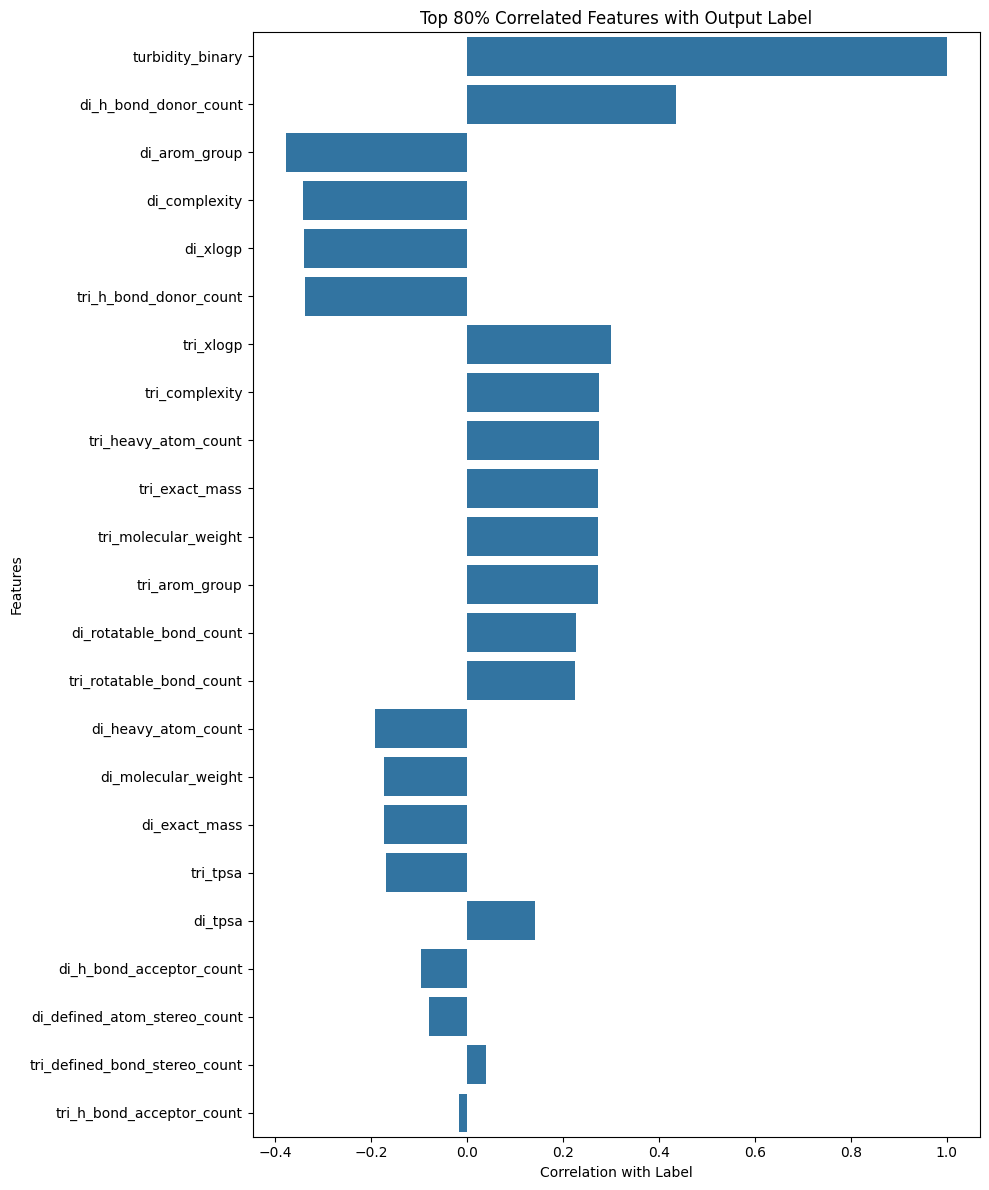

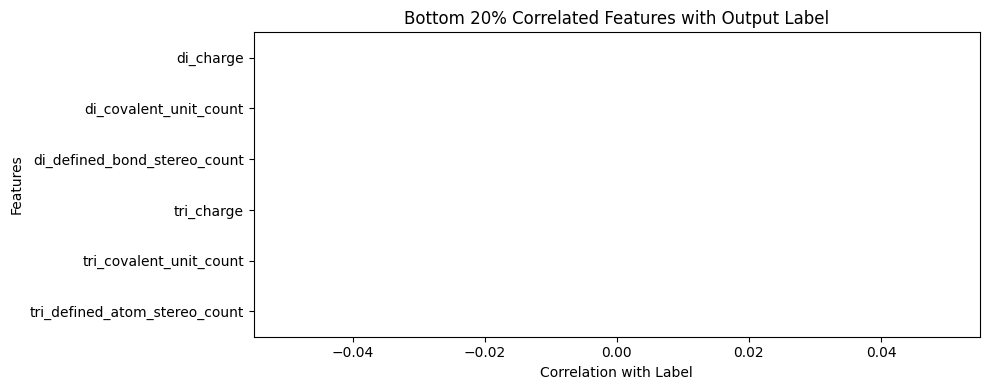

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sorted_features = correlation_with_label.abs().sort_values(ascending=False)

split_index = int(0.8 * len(sorted_features))

top_80_percent_features = sorted_features.iloc[:split_index].index.tolist()  # Top 80% features
bottom_20_percent_features = sorted_features.iloc[split_index:].index.tolist()  # Bottom 20% features

print("Top 80% Most Correlated Features:", top_80_percent_features)
print("Bottom 20% Least Correlated Features:", bottom_20_percent_features)

plt.figure(figsize=(10, 12))
sns.barplot(
    y=correlation_with_label.loc[top_80_percent_features].index,
    x=correlation_with_label.loc[top_80_percent_features].values,
    orient='h'
)
plt.ylabel('Features')
plt.xlabel('Correlation with Label')
plt.title('Top 80% Correlated Features with Output Label')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(
    y=correlation_with_label.loc[bottom_20_percent_features].index,
    x=correlation_with_label.loc[bottom_20_percent_features].values,
    orient='h'
)
plt.ylabel('Features')
plt.xlabel('Correlation with Label')
plt.title('Bottom 20% Correlated Features with Output Label')
plt.tight_layout()
plt.show()


# Perform a new GNN training with these cleanned features (more correlated)

In [5]:
data_all = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/all_dataset_turbidity.csv')

In [6]:
data_all.columns

Index(['Unnamed: 0', 'di_name', 'tri_name', 'di_smiles', 'tri_smiles',
       'turbidity_label', 'turbidity', 'turbidity_binary', 'di_charge',
       'di_complexity', 'di_covalent_unit_count',
       'di_defined_atom_stereo_count', 'di_defined_bond_stereo_count',
       'di_exact_mass', 'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_heavy_atom_count', 'di_xlogp', 'di_molecular_weight',
       'di_rotatable_bond_count', 'di_tpsa', 'tri_charge', 'tri_complexity',
       'tri_covalent_unit_count', 'tri_defined_atom_stereo_count',
       'tri_defined_bond_stereo_count', 'tri_exact_mass',
       'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
       'tri_heavy_atom_count', 'tri_xlogp', 'tri_molecular_weight',
       'tri_rotatable_bond_count', 'tri_tpsa', 'di_arom_group',
       'tri_arom_group'],
      dtype='object')

In [7]:
def load_and_filter_df_cleanned(df):
    
    required_columns = [
        'turbidity_binary', 'di_smiles', 'tri_smiles', 'di_h_bond_donor_count', 'di_arom_group', 'di_complexity',
        'di_xlogp', 'tri_h_bond_donor_count', 'tri_xlogp', 'tri_complexity', 'tri_heavy_atom_count',
        'tri_exact_mass', 'tri_molecular_weight', 'tri_arom_group', 'di_rotatable_bond_count', 'tri_rotatable_bond_count', 
        'di_heavy_atom_count', 'di_molecular_weight', 'di_exact_mass', 'tri_tpsa', 'di_tpsa', 'di_h_bond_acceptor_count',
        'di_defined_atom_stereo_count', 'tri_defined_bond_stereo_count', 'tri_h_bond_acceptor_count'
        ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    
    filtered_df = df[available_columns]

    filtered_df.fillna('unknown', inplace=True)

    return filtered_df


In [8]:
data_all = load_and_filter_df_cleanned(data_all)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_52339/2895454578.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)


In [9]:
data_all

,turbidity_binary,di_smiles,tri_smiles,di_h_bond_donor_count,di_arom_group,di_complexity,di_xlogp,tri_h_bond_donor_count,tri_xlogp,tri_complexity,...,tri_rotatable_bond_count,di_heavy_atom_count,di_molecular_weight,di_exact_mass,tri_tpsa,di_tpsa,di_h_bond_acceptor_count,di_defined_atom_stereo_count,tri_defined_bond_stereo_count,tri_h_bond_acceptor_count
0,0,O=Cc1cccc(C=O)c1,Nc1nc(N)nc(N)n1,0,1,117.0,1.2,3.0,-1.4,63.3,...,0.0,10,134.13,134.036779,117.0,34.1,2,0,0.0,6.0
1,0,CC(C)(C)c1cc(C=O)c(O)c(C=O)c1,Nc1nc(N)nc(N)n1,1,1,224.0,2.7,3.0,-1.4,63.3,...,0.0,15,206.24,206.094294,117.0,54.4,3,0,0.0,6.0
2,0,O=Cc1cc2sc(C=O)cc2s1,Nc1nc(N)nc(N)n1,0,2,185.0,2.3,3.0,-1.4,63.3,...,0.0,12,196.30,195.965272,117.0,90.6,4,0,0.0,6.0
3,0,O=Cc1ccc(C=O)cc1,Nc1nc(N)nc(N)n1,0,1,107.0,0.9,3.0,-1.4,63.3,...,0.0,10,134.13,134.036779,117.0,34.1,2,0,0.0,6.0
4,0,O=Cc1c(F)c(F)c(C=O)c(F)c1F,Nc1nc(N)nc(N)n1,0,1,195.0,1.2,3.0,-1.4,63.3,...,0.0,14,206.09,205.999092,117.0,34.1,6,0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1,NCCOCCN,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,2,0,28.9,-1.8,0.0,7.1,654.0,...,9.0,7,104.15,104.094963,51.2,61.3,3,0,3.0,3.0
344,1,NCC1=CC(CN)=CC=C1,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,2,1,83.3,-0.3,0.0,7.1,654.0,...,9.0,10,136.19,136.100048,51.2,52.0,2,0,3.0,3.0
345,1,NCC(CN)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,3,0,28.0,-2.3,0.0,7.1,654.0,...,9.0,6,90.12,90.079313,51.2,72.3,3,0,3.0,3.0
346,1,NCCCC[C@H](N)C(=O)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,3,0,106.0,-3.0,0.0,7.1,654.0,...,9.0,10,146.19,146.105528,51.2,89.3,4,1,3.0,3.0


In [39]:
exclude_columns = [
        'turbidity_binary', 'di_smiles', 'tri_smiles', 'di_h_bond_donor_count', 'di_arom_group',
        'tri_h_bond_donor_count', 'tri_heavy_atom_count',
        'tri_arom_group', 'di_rotatable_bond_count', 'tri_rotatable_bond_count', 
        'di_heavy_atom_count', 'di_h_bond_acceptor_count',
        'di_defined_atom_stereo_count', 'tri_defined_bond_stereo_count', 'tri_h_bond_acceptor_count'
        ]

data_to_normalize = data_all.drop(columns=exclude_columns)
data_excluded = data_all[exclude_columns]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_df = pd.DataFrame(normalized_data, columns=data_to_normalize.columns)

final_df = pd.concat([normalized_df, data_excluded], axis=1)

final_df = final_df[data_all.columns]

normalized_df = pd.DataFrame(final_df)

In [40]:
normalized_df

,turbidity_binary,di_smiles,tri_smiles,di_h_bond_donor_count,di_arom_group,di_complexity,di_xlogp,tri_h_bond_donor_count,tri_xlogp,tri_complexity,...,tri_rotatable_bond_count,di_heavy_atom_count,di_molecular_weight,di_exact_mass,tri_tpsa,di_tpsa,di_h_bond_acceptor_count,di_defined_atom_stereo_count,tri_defined_bond_stereo_count,tri_h_bond_acceptor_count
0,0,O=Cc1cccc(C=O)c1,Nc1nc(N)nc(N)n1,0,1,0.320809,0.608696,3.0,0.123711,0.014090,...,0.0,10,0.273982,0.273913,0.775943,0.000000,2,0,0.0,6.0
1,0,CC(C)(C)c1cc(C=O)c(O)c(C=O)c1,Nc1nc(N)nc(N)n1,1,1,0.630058,0.826087,3.0,0.123711,0.014090,...,0.0,15,0.540859,0.540752,0.775943,0.356766,3,0,0.0,6.0
2,0,O=Cc1cc2sc(C=O)cc2s1,Nc1nc(N)nc(N)n1,0,2,0.517341,0.768116,3.0,0.123711,0.014090,...,0.0,12,0.504071,0.503243,0.775943,0.992970,4,0,0.0,6.0
3,0,O=Cc1ccc(C=O)cc1,Nc1nc(N)nc(N)n1,0,1,0.291908,0.565217,3.0,0.123711,0.014090,...,0.0,10,0.273982,0.273913,0.775943,0.000000,2,0,0.0,6.0
4,0,O=Cc1c(F)c(F)c(C=O)c(F)c1F,Nc1nc(N)nc(N)n1,0,1,0.546243,0.608696,3.0,0.123711,0.014090,...,0.0,14,0.540303,0.540400,0.775943,0.000000,6,0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1,NCCOCCN,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,2,0,0.066185,0.173913,0.0,1.000000,0.784736,...,9.0,7,0.163027,0.163035,0.000000,0.478032,3,0,3.0,3.0
344,1,NCC1=CC(CN)=CC=C1,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,2,1,0.223410,0.391304,0.0,1.000000,0.784736,...,9.0,10,0.281606,0.281554,0.000000,0.314587,2,0,3.0,3.0
345,1,NCC(CN)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,3,0,0.063584,0.101449,0.0,1.000000,0.784736,...,9.0,6,0.111103,0.111133,0.000000,0.671353,3,0,3.0,3.0
346,1,NCCCC[C@H](N)C(=O)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,3,0,0.289017,0.000000,0.0,1.000000,0.784736,...,9.0,10,0.318616,0.318606,0.000000,0.970123,4,1,3.0,3.0


In [41]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum(), int(atom.GetDegree()), int(atom.GetIsAromatic())])
    
    atom_features = torch.tensor(atom_features, dtype=torch.float)
    
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append([i, j])
        edges.append([j, i])  
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  

    data = Data(x=atom_features, edge_index=edge_index)
    return data


In [43]:
normalized_df.columns

Index(['turbidity_binary', 'di_smiles', 'tri_smiles', 'di_h_bond_donor_count',
       'di_arom_group', 'di_complexity', 'di_xlogp', 'tri_h_bond_donor_count',
       'tri_xlogp', 'tri_complexity', 'tri_heavy_atom_count', 'tri_exact_mass',
       'tri_molecular_weight', 'tri_arom_group', 'di_rotatable_bond_count',
       'tri_rotatable_bond_count', 'di_heavy_atom_count',
       'di_molecular_weight', 'di_exact_mass', 'tri_tpsa', 'di_tpsa',
       'di_h_bond_acceptor_count', 'di_defined_atom_stereo_count',
       'tri_defined_bond_stereo_count', 'tri_h_bond_acceptor_count'],
      dtype='object')

In [45]:
from rdkit import Chem

def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None  
    except Exception as e:
        print(f"Error validating SMILES {smiles}: {e}")
        return False


In [44]:
normalized_df['di_smiles_valid'] = normalized_df['di_smiles'].apply(is_valid_smiles)
normalized_df['tri_smiles_valid'] = normalized_df['tri_smiles'].apply(is_valid_smiles)

valid_rows = normalized_df[normalized_df['di_smiles_valid'] & normalized_df['tri_smiles_valid']]
invalid_rows = normalized_df[~(normalized_df['di_smiles_valid'] & normalized_df['tri_smiles_valid'])]
print(f"Invalid SMILES entries:\n{invalid_rows[['di_smiles', 'tri_smiles']]}")

Invalid SMILES entries:
Empty DataFrame
Columns: [di_smiles, tri_smiles]
Index: []


In [46]:
normalized_df

,turbidity_binary,di_smiles,tri_smiles,di_h_bond_donor_count,di_arom_group,di_complexity,di_xlogp,tri_h_bond_donor_count,tri_xlogp,tri_complexity,...,di_molecular_weight,di_exact_mass,tri_tpsa,di_tpsa,di_h_bond_acceptor_count,di_defined_atom_stereo_count,tri_defined_bond_stereo_count,tri_h_bond_acceptor_count,di_smiles_valid,tri_smiles_valid
0,0,O=Cc1cccc(C=O)c1,Nc1nc(N)nc(N)n1,0,1,0.320809,0.608696,3.0,0.123711,0.014090,...,0.273982,0.273913,0.775943,0.000000,2,0,0.0,6.0,True,True
1,0,CC(C)(C)c1cc(C=O)c(O)c(C=O)c1,Nc1nc(N)nc(N)n1,1,1,0.630058,0.826087,3.0,0.123711,0.014090,...,0.540859,0.540752,0.775943,0.356766,3,0,0.0,6.0,True,True
2,0,O=Cc1cc2sc(C=O)cc2s1,Nc1nc(N)nc(N)n1,0,2,0.517341,0.768116,3.0,0.123711,0.014090,...,0.504071,0.503243,0.775943,0.992970,4,0,0.0,6.0,True,True
3,0,O=Cc1ccc(C=O)cc1,Nc1nc(N)nc(N)n1,0,1,0.291908,0.565217,3.0,0.123711,0.014090,...,0.273982,0.273913,0.775943,0.000000,2,0,0.0,6.0,True,True
4,0,O=Cc1c(F)c(F)c(C=O)c(F)c1F,Nc1nc(N)nc(N)n1,0,1,0.546243,0.608696,3.0,0.123711,0.014090,...,0.540303,0.540400,0.775943,0.000000,6,0,0.0,6.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1,NCCOCCN,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,2,0,0.066185,0.173913,0.0,1.000000,0.784736,...,0.163027,0.163035,0.000000,0.478032,3,0,3.0,3.0,True,True
344,1,NCC1=CC(CN)=CC=C1,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,2,1,0.223410,0.391304,0.0,1.000000,0.784736,...,0.281606,0.281554,0.000000,0.314587,2,0,3.0,3.0,True,True
345,1,NCC(CN)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,3,0,0.063584,0.101449,0.0,1.000000,0.784736,...,0.111103,0.111133,0.000000,0.671353,3,0,3.0,3.0,True,True
346,1,NCCCC[C@H](N)C(=O)O,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,3,0,0.289017,0.000000,0.0,1.000000,0.784736,...,0.318616,0.318606,0.000000,0.970123,4,1,3.0,3.0,True,True


# Node feature augmentations

In [47]:
normalized_df.columns

Index(['turbidity_binary', 'di_smiles', 'tri_smiles', 'di_h_bond_donor_count',
       'di_arom_group', 'di_complexity', 'di_xlogp', 'tri_h_bond_donor_count',
       'tri_xlogp', 'tri_complexity', 'tri_heavy_atom_count', 'tri_exact_mass',
       'tri_molecular_weight', 'tri_arom_group', 'di_rotatable_bond_count',
       'tri_rotatable_bond_count', 'di_heavy_atom_count',
       'di_molecular_weight', 'di_exact_mass', 'tri_tpsa', 'di_tpsa',
       'di_h_bond_acceptor_count', 'di_defined_atom_stereo_count',
       'tri_defined_bond_stereo_count', 'tri_h_bond_acceptor_count',
       'di_smiles_valid', 'tri_smiles_valid'],
      dtype='object')

In [48]:
data_list = []

for index, row in normalized_df.iterrows():
    try:
        ditopic_graph = smiles_to_graph(row['di_smiles'])
        tritopic_graph = smiles_to_graph(row['tri_smiles'])

        if ditopic_graph is None or tritopic_graph is None:
            print(f"Error processing row {index}: Invalid SMILES")
            continue

        if ditopic_graph.x is None or tritopic_graph.x is None:
            print(f"Error processing row {index}: Graph returned without node features")
            continue

        ditopic_features = torch.tensor([
            
            row['di_h_bond_donor_count'], 
            row['di_xlogp'],
            row['di_tpsa'],
            row['di_arom_group'],
            row['di_complexity'],
            row['di_exact_mass'],
            row['di_heavy_atom_count'],
            row['di_molecular_weight'],
            row['di_rotatable_bond_count']
        ], dtype=torch.float)

        tritopic_features = torch.tensor([
            
            row['tri_h_bond_donor_count'],
            row['tri_xlogp'],
            row['tri_tpsa'],
            row['tri_arom_group'],
            row['tri_complexity'],
            row['tri_exact_mass'],
            row['tri_heavy_atom_count'],
            row['tri_molecular_weight'],
            row['tri_rotatable_bond_count']
        ], dtype=torch.float)

        print(f"Row {index}: ditopic_graph.x shape before augmentation: {ditopic_graph.x.shape}")
        print(f"ditopic_features shape: {ditopic_features.shape}")

       
        ditopic_graph.x = torch.cat(
            [ditopic_graph.x, ditopic_features.expand(ditopic_graph.x.size(0), -1)], dim=1
        )
        tritopic_graph.x = torch.cat(
            [tritopic_graph.x, tritopic_features.expand(tritopic_graph.x.size(0), -1)], dim=1
        )

        label = torch.tensor(row['turbidity_binary'], dtype=torch.float)

        data_list.append((ditopic_graph, tritopic_graph, label))

    except KeyError as e:
        print(f"KeyError processing row {index}: {e}")
    except ValueError as e:
        print(f"ValueError processing row {index}: {e}")
    except Exception as e:
        print(f"Error processing row {index}: {e}")


Row 0: ditopic_graph.x shape before augmentation: torch.Size([10, 3])
ditopic_features shape: torch.Size([9])
Row 1: ditopic_graph.x shape before augmentation: torch.Size([15, 3])
ditopic_features shape: torch.Size([9])
Row 2: ditopic_graph.x shape before augmentation: torch.Size([12, 3])
ditopic_features shape: torch.Size([9])
Row 3: ditopic_graph.x shape before augmentation: torch.Size([10, 3])
ditopic_features shape: torch.Size([9])
Row 4: ditopic_graph.x shape before augmentation: torch.Size([14, 3])
ditopic_features shape: torch.Size([9])
Row 5: ditopic_graph.x shape before augmentation: torch.Size([16, 3])
ditopic_features shape: torch.Size([9])
Row 6: ditopic_graph.x shape before augmentation: torch.Size([18, 3])
ditopic_features shape: torch.Size([9])
Row 7: ditopic_graph.x shape before augmentation: torch.Size([18, 3])
ditopic_features shape: torch.Size([9])
Row 8: ditopic_graph.x shape before augmentation: torch.Size([9, 3])
ditopic_features shape: torch.Size([9])
Row 9: dito

In [49]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

train_dataset = ReactionDataset(train_data)
test_dataset = ReactionDataset(test_data)


In [50]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ReactionGNN(nn.Module):
    def __init__(self, node_input_dim, hidden_dim, output_dim, num_global_features):
        super(ReactionGNN, self).__init__()
        
        updated_node_input_dim = node_input_dim  

        self.conv1_a = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_a = GCNConv(hidden_dim, hidden_dim)
        self.conv3_a = GCNConv(hidden_dim, hidden_dim)  

        self.conv1_b = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_b = GCNConv(hidden_dim, hidden_dim)
        self.conv3_b = GCNConv(hidden_dim, hidden_dim)  

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, data_a, data_b):
        
        x_a, edge_index_a, batch_a = data_a.x, data_a.edge_index, data_a.batch
        x_a = self.relu(self.conv1_a(x_a, edge_index_a))
        x_a = self.relu(self.conv2_a(x_a, edge_index_a))
        x_a = self.relu(self.conv3_a(x_a, edge_index_a))
        x_a = global_mean_pool(x_a, batch_a)

        x_b, edge_index_b, batch_b = data_b.x, data_b.edge_index, data_b.batch
        x_b = self.relu(self.conv1_b(x_b, edge_index_b))
        x_b = self.relu(self.conv2_b(x_b, edge_index_b))
        x_b = self.relu(self.conv3_b(x_b, edge_index_b))
        x_b = global_mean_pool(x_b, batch_b)

        combined = torch.cat([x_a, x_b], dim=1)
          
        x = self.relu(self.fc1(combined))  # Should have input size of hidden_dim * 2
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  # Should have input size of hidden_dim
        x = self.batch_norm2(x)
        x = self.dropout(x)
        out = self.fc3(x)  # Should have input size of hidden_dim // 2

        return out


In [52]:
node_input_dim = 12
hidden_dim = 512
output_dim = 1
feature_dim = 5 
num_global_features = 14

Starting experiment 1/3
Experiment 1, Epoch 1/100, Loss: 0.6315
Experiment 1, Epoch 2/100, Loss: 0.5266
Experiment 1, Epoch 3/100, Loss: 0.5316
Experiment 1, Epoch 4/100, Loss: 0.5136
Experiment 1, Epoch 5/100, Loss: 0.4765
Experiment 1, Epoch 6/100, Loss: 0.4807
Experiment 1, Epoch 7/100, Loss: 0.4887
Experiment 1, Epoch 8/100, Loss: 0.4871
Experiment 1, Epoch 9/100, Loss: 0.5015
Experiment 1, Epoch 10/100, Loss: 0.4412
Experiment 1, Accuracy after Epoch 10: 72.86 %
Predicted Turbid (1): 26, Predicted Dissolved (0): 44
Experiment 1, Epoch 11/100, Loss: 0.5015
Experiment 1, Epoch 12/100, Loss: 0.4694
Experiment 1, Epoch 13/100, Loss: 0.4852
Experiment 1, Epoch 14/100, Loss: 0.5044
Experiment 1, Epoch 15/100, Loss: 0.4805
Experiment 1, Epoch 16/100, Loss: 0.4608
Experiment 1, Epoch 17/100, Loss: 0.4359
Experiment 1, Epoch 18/100, Loss: 0.4459
Experiment 1, Epoch 19/100, Loss: 0.4504
Experiment 1, Epoch 20/100, Loss: 0.4617
Experiment 1, Accuracy after Epoch 20: 65.71 %
Predicted Turbid 

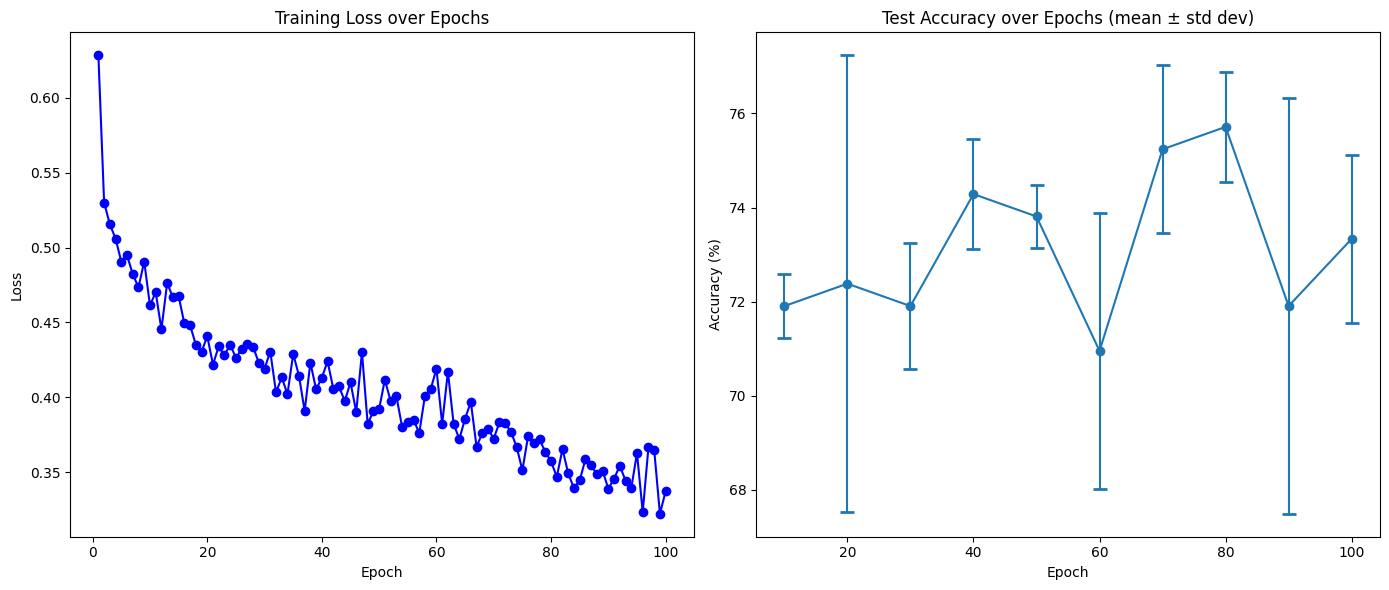

In [55]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader, num_epochs=100, num_experiments=3, accuracy_every_n_epochs=10, device='cuda'):
    all_epoch_losses = []
    all_epoch_accuracies = []

    for experiment in range(num_experiments):
        print(f"Starting experiment {experiment + 1}/{num_experiments}")

        model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        criterion = nn.BCEWithLogitsLoss()

        epoch_losses = []
        epoch_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for ditopic_graph, tritopic_graph, label in train_loader:
                ditopic_graph = ditopic_graph
                tritopic_graph = tritopic_graph
                label = label.float()  

                optimizer.zero_grad()

                out = model(ditopic_graph, tritopic_graph).squeeze()
                loss = criterion(out, label)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            epoch_losses.append(avg_loss)
            print(f'Experiment {experiment + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

            if (epoch + 1) % accuracy_every_n_epochs == 0:
                model.eval()
                correct = 0
                total = 0
                predicted_turbid = 0  
                predicted_dissolved = 0  

                with torch.no_grad():
                    for ditopic_graph, tritopic_graph, label in test_loader:
                        ditopic_graph = ditopic_graph
                        tritopic_graph = tritopic_graph
                        label = label

                        out = model(ditopic_graph, tritopic_graph)

                        probs = torch.sigmoid(out)
                        preds = probs.round()  

                        correct += (preds.squeeze() == label).sum().item()
                        total += label.size(0)

                        predicted_turbid += (preds == 1).sum().item()
                        predicted_dissolved += (preds == 0).sum().item()

                accuracy = 100 * correct / total
                epoch_accuracies.append(accuracy)
                print(f'Experiment {experiment + 1}, Accuracy after Epoch {epoch + 1}: {accuracy:.2f} %')
                print(f'Predicted Turbid (1): {predicted_turbid}, Predicted Dissolved (0): {predicted_dissolved}')

        all_epoch_losses.append(epoch_losses)
        all_epoch_accuracies.append(epoch_accuracies)

    all_epoch_losses = np.array(all_epoch_losses)
    all_epoch_accuracies = np.array(all_epoch_accuracies)

    mean_accuracies = np.nanmean(all_epoch_accuracies, axis=0)
    std_accuracies = np.nanstd(all_epoch_accuracies, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    mean_losses = np.mean(all_epoch_losses, axis=0)
    ax1.plot(range(1, num_epochs + 1), mean_losses, marker='o', color='b', label="Training Loss")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss over Epochs')
    ax1.grid(False)

    epochs_with_accuracy = range(accuracy_every_n_epochs, num_epochs + 1, accuracy_every_n_epochs)

    ax2.errorbar(
        epochs_with_accuracy,
        mean_accuracies,
        yerr=std_accuracies,
        fmt='-o',         
        capsize=5,           
        capthick=2,     
        label="Test Accuracy"
    )
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Test Accuracy over Epochs (mean ± std dev)')
    ax2.grid(False)

    plt.tight_layout()
    plt.show()


train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader)


Starting experiment 1/3
Experiment 1, Accuracy after Epoch 10: 0.71 %
Experiment 1, Accuracy after Epoch 20: 0.67 %
Experiment 1, Accuracy after Epoch 30: 0.74 %
Experiment 1, Accuracy after Epoch 40: 0.67 %
Experiment 1, Accuracy after Epoch 50: 0.71 %
Experiment 1, Accuracy after Epoch 60: 0.74 %
Experiment 1, Accuracy after Epoch 70: 0.74 %
Experiment 1, Accuracy after Epoch 80: 0.77 %
Experiment 1, Accuracy after Epoch 90: 0.74 %
Experiment 1, Accuracy after Epoch 100: 0.76 %
Starting experiment 2/3
Experiment 2, Accuracy after Epoch 10: 0.76 %
Experiment 2, Accuracy after Epoch 20: 0.73 %
Experiment 2, Accuracy after Epoch 30: 0.73 %
Experiment 2, Accuracy after Epoch 40: 0.74 %
Experiment 2, Accuracy after Epoch 50: 0.73 %
Experiment 2, Accuracy after Epoch 60: 0.71 %
Experiment 2, Accuracy after Epoch 70: 0.76 %
Experiment 2, Accuracy after Epoch 80: 0.79 %
Experiment 2, Accuracy after Epoch 90: 0.77 %
Experiment 2, Accuracy after Epoch 100: 0.74 %
Starting experiment 3/3
Experi

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_52339/2972603932.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


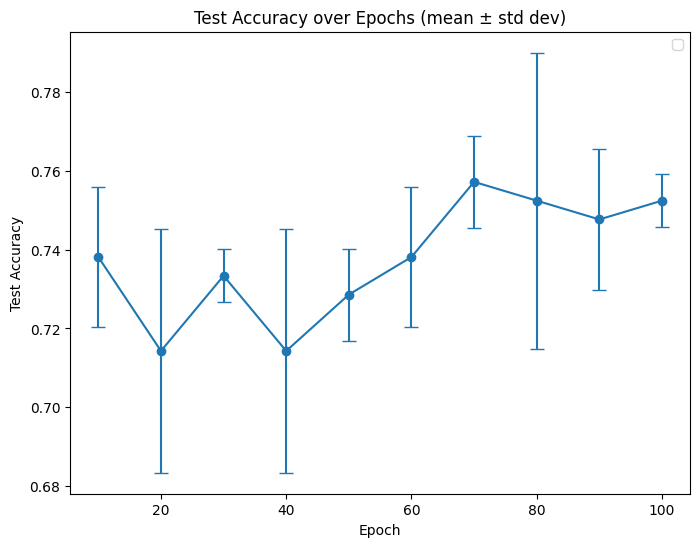

In [65]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader, num_epochs=100, num_experiments=3, accuracy_every_n_epochs=10, device='cuda'):
    all_epoch_accuracies = []

    for experiment in range(num_experiments):
        print(f"Starting experiment {experiment + 1}/{num_experiments}")

        model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        criterion = nn.BCEWithLogitsLoss()

        epoch_accuracies = []

        for epoch in range(num_epochs):
            model.train()

            for ditopic_graph, tritopic_graph, label in train_loader:
                ditopic_graph = ditopic_graph
                tritopic_graph = tritopic_graph
                label = label.float()  

                optimizer.zero_grad()

                out = model(ditopic_graph, tritopic_graph).squeeze()
                loss = criterion(out, label)

                loss.backward()
                optimizer.step()

            if (epoch + 1) % accuracy_every_n_epochs == 0:
                model.eval()
                correct = 0
                total = 0

                with torch.no_grad():
                    for ditopic_graph, tritopic_graph, label in test_loader:
                        ditopic_graph = ditopic_graph
                        tritopic_graph = tritopic_graph
                        label = label

                        out = model(ditopic_graph, tritopic_graph)

                        probs = torch.sigmoid(out)
                        preds = probs.round() 

                        correct += (preds.squeeze() == label).sum().item()
                        total += label.size(0)

   
                accuracy = correct / total
                epoch_accuracies.append(accuracy)
                print(f'Experiment {experiment + 1}, Accuracy after Epoch {epoch + 1}: {accuracy:.2f} %')


        all_epoch_accuracies.append(epoch_accuracies)

    all_epoch_accuracies = np.array(all_epoch_accuracies)

    mean_accuracies = np.nanmean(all_epoch_accuracies, axis=0)
    std_accuracies = np.nanstd(all_epoch_accuracies, axis=0)

    plt.figure(figsize=(8, 6))
    epochs_with_accuracy = range(accuracy_every_n_epochs, num_epochs + 1, accuracy_every_n_epochs)
    plt.errorbar(
        epochs_with_accuracy,
        mean_accuracies,
        yerr=std_accuracies,
        fmt='-o',
        capsize=5,
    )
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy over Epochs (mean ± std dev)')
    plt.grid(False)
    plt.legend()
    plt.show()

train_and_evaluate_gcn(node_input_dim, hidden_dim, output_dim, num_global_features, train_loader, test_loader)


# Let's try training on one cluster

In [423]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ditopic_feature_columns = [
    'di_h_bond_donor_count', 'di_xlogp', 'di_tpsa', 'di_nbr_arom', 'di_complexity', 
    'di_exact_mass', 'di_heavy_atom_count', 'di_molecular_weight', 'di_rotatable_bond_count'
]

tritopic_feature_columns = [
    'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa', 'tri_nbr_arom', 'tri_complexity', 
    'tri_exact_mass', 'tri_heavy_atom_count', 'tri_molecular_weight', 'tri_rotatable_bond_count'
]


combined_feature_columns = ditopic_feature_columns + tritopic_feature_columns

feature_df = normalized_df[combined_feature_columns]




In [424]:
feature_df

,di_h_bond_donor_count,di_xlogp,di_tpsa,di_nbr_arom,di_complexity,di_exact_mass,di_heavy_atom_count,di_molecular_weight,di_rotatable_bond_count,tri_h_bond_donor_count,tri_xlogp,tri_tpsa,tri_nbr_arom,tri_complexity,tri_exact_mass,tri_heavy_atom_count,tri_molecular_weight,tri_rotatable_bond_count
0,0.0,0.608696,0.000000,1,0.320809,0.273913,0.3,0.273982,0.166667,3.0,0.123711,0.775943,1,0.014090,0.000000,0.000000,0.000000,0.00
1,0.0,0.608696,0.000000,1,0.320809,0.273913,0.3,0.273982,0.166667,3.0,0.226804,0.317217,1,0.119374,0.229060,0.222222,0.229133,0.25
2,0.0,0.608696,0.000000,1,0.320809,0.273913,0.3,0.273982,0.166667,3.0,0.000000,0.354953,0,0.000000,0.056730,0.037037,0.056747,0.50
3,0.0,0.608696,0.000000,1,0.320809,0.273913,0.3,0.273982,0.166667,3.0,0.360825,0.317217,1,0.161122,0.347805,0.333333,0.347847,0.50
4,0.0,0.608696,0.000000,1,0.320809,0.273913,0.3,0.273982,0.166667,3.0,0.113402,0.354953,0,0.034051,0.175476,0.148148,0.175490,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2.0,0.376812,0.314587,1,0.194509,0.281554,0.3,0.281606,0.166667,0.0,0.927835,0.000000,4,1.000000,0.949076,1.000000,0.949207,0.75
351,2.0,0.376812,0.314587,1,0.194509,0.281554,0.3,0.281606,0.166667,0.0,0.804124,0.000000,4,0.575995,0.745739,0.777778,0.745753,0.50
352,2.0,0.376812,0.314587,1,0.194509,0.281554,0.3,0.281606,0.166667,0.0,0.804124,0.000000,4,0.575995,0.745739,0.777778,0.745753,0.50
353,2.0,0.376812,0.314587,1,0.194509,0.281554,0.3,0.281606,0.166667,0.0,0.804124,1.000000,4,0.543379,0.796204,0.666667,0.796828,0.50


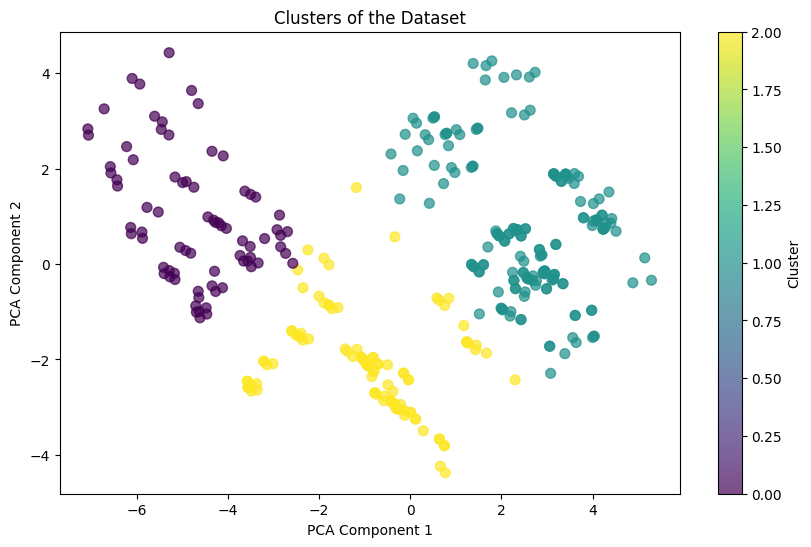

In [430]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

normalized_df['cluster'] = clusters

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of the Dataset')
plt.colorbar(label='Cluster')
plt.show()

In [439]:
import pandas as pd

numeric_df = normalized_df.select_dtypes(include=['number'])

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(numeric_df)

labels = kmeans.labels_

normalized_df['cluster'] = labels

cluster_0_df = normalized_df[normalized_df['cluster'] == 0].drop(columns=['cluster'])
cluster_1_df = normalized_df[normalized_df['cluster'] == 1].drop(columns=['cluster'])
cluster_2_df = normalized_df[normalized_df['cluster'] == 2].drop(columns=['cluster'])




In [444]:
cluster_1_df

,turbidity_label,di_smiles,tri_smiles,di_complexity,di_exact_mass,di_h_bond_donor_count,di_heavy_atom_count,di_xlogp,di_molecular_weight,di_rotatable_bond_count,...,tri_h_bond_donor_count,tri_heavy_atom_count,tri_xlogp,tri_molecular_weight,tri_rotatable_bond_count,tri_tpsa,di_nbr_arom,tri_nbr_arom,di_smiles_valid,tri_smiles_valid
49,1,NCCN,O=Cc1ccc(-c2cc(-c3ccc(C=O)cc3)cc(-c3ccc(C=O)cc...,0.000000,0.000000,2.0,0.00,0.144928,0.000000,0.083333,...,0.0,0.777778,0.804124,0.745753,0.50,0.000000,0,4,True,True
51,0,NCCN,O=Cc1ccc(N(c2ccc(C=O)cc2)c2ccc(C=O)cc2)cc1,0.000000,0.000000,2.0,0.00,0.144928,0.000000,0.083333,...,0.0,0.592593,0.628866,0.573339,0.50,0.037736,0,3,True,True
52,1,NCCN,O=Cc1ccc(-c2nc(-c3ccc(C=O)cc3)nc(-c3ccc(C=O)cc...,0.000000,0.000000,2.0,0.00,0.144928,0.000000,0.083333,...,0.0,0.777778,0.608247,0.754219,0.50,0.456368,0,4,True,True
53,0,NCCN,O=Cc1ccc(C#Cc2cc(C#Cc3ccc(C=O)cc3)cc(C#Cc3ccc(...,0.000000,0.000000,2.0,0.00,0.144928,0.000000,0.083333,...,0.0,1.000000,0.927835,0.949207,0.75,0.000000,0,4,True,True
55,0,CC(C)(CN)CN,O=Cc1ccc(-c2cc(-c3ccc(C=O)cc3)cc(-c3ccc(C=O)cc...,0.109827,0.155705,2.0,0.15,0.362319,0.155736,0.166667,...,0.0,0.777778,0.804124,0.745753,0.50,0.000000,0,4,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,0,NCc1ccc(CN)cc1,O=Cc1ccc(C#Cc2cc(C#Cc3ccc(C=O)cc3)cc(C#Cc3ccc(...,0.194509,0.281554,2.0,0.30,0.376812,0.281606,0.166667,...,0.0,1.000000,0.927835,0.949207,0.75,0.000000,1,4,True,True
351,1,NCc1ccc(CN)cc1,O=Cc1cccc(-c2cc(-c3cccc(C=O)c3)cc(-c3cccc(C=O)...,0.194509,0.281554,2.0,0.30,0.376812,0.281606,0.166667,...,0.0,0.777778,0.804124,0.745753,0.50,0.000000,1,4,True,True
352,1,NCc1ccc(CN)cc1,O=Cc1ccccc1-c1cc(-c2ccccc2C=O)cc(-c2ccccc2C=O)c1,0.194509,0.281554,2.0,0.30,0.376812,0.281606,0.166667,...,0.0,0.777778,0.804124,0.745753,0.50,0.000000,1,4,True,True
353,1,NCc1ccc(CN)cc1,O=Cc1cc(-c2cc(-c3csc(C=O)c3)cc(-c3csc(C=O)c3)c...,0.194509,0.281554,2.0,0.30,0.376812,0.281606,0.166667,...,0.0,0.666667,0.804124,0.796828,0.50,1.000000,1,4,True,True


In [453]:
data_list = []

for index, row in cluster_1_df.iterrows():
    try:
    
        ditopic_graph = smiles_to_graph(row['di_smiles'])
        tritopic_graph = smiles_to_graph(row['tri_smiles'])

      
        if ditopic_graph is None or tritopic_graph is None:
            print(f"Error processing row {index}: Invalid SMILES")
            continue

        if ditopic_graph.x is None or tritopic_graph.x is None:
            print(f"Error processing row {index}: Graph returned without node features")
            continue

    
        ditopic_features = torch.tensor([
            
            row['di_h_bond_donor_count'],
            row['di_xlogp'],
            row['di_tpsa'],
            row['di_nbr_arom'],
            row['di_complexity'],
            row['di_exact_mass'],
            row['di_heavy_atom_count'],
            row['di_molecular_weight'],
            row['di_rotatable_bond_count']
        ], dtype=torch.float)

        tritopic_features = torch.tensor([
            
            row['tri_h_bond_donor_count'],
            row['tri_xlogp'],
            row['tri_tpsa'],
            row['tri_nbr_arom'],
            row['tri_complexity'],
            row['tri_exact_mass'],
            row['tri_heavy_atom_count'],
            row['tri_molecular_weight'],
            row['tri_rotatable_bond_count']
        ], dtype=torch.float)

    
        print(f"Row {index}: ditopic_graph.x shape before augmentation: {ditopic_graph.x.shape}")
        print(f"ditopic_features shape: {ditopic_features.shape}")

 
        ditopic_graph.x = torch.cat(
            [ditopic_graph.x, ditopic_features.expand(ditopic_graph.x.size(0), -1)], dim=1
        )
        tritopic_graph.x = torch.cat(
            [tritopic_graph.x, tritopic_features.expand(tritopic_graph.x.size(0), -1)], dim=1
        )


        label = torch.tensor(row['turbidity_label'], dtype=torch.float)

      
        data_list.append((ditopic_graph, tritopic_graph, label))

    except KeyError as e:
        print(f"KeyError processing row {index}: {e}")
    except ValueError as e:
        print(f"ValueError processing row {index}: {e}")
    except Exception as e:
        print(f"Error processing row {index}: {e}")


Row 49: ditopic_graph.x shape before augmentation: torch.Size([4, 3])
ditopic_features shape: torch.Size([9])
Row 51: ditopic_graph.x shape before augmentation: torch.Size([4, 3])
ditopic_features shape: torch.Size([9])
Row 52: ditopic_graph.x shape before augmentation: torch.Size([4, 3])
ditopic_features shape: torch.Size([9])
Row 53: ditopic_graph.x shape before augmentation: torch.Size([4, 3])
ditopic_features shape: torch.Size([9])
Row 55: ditopic_graph.x shape before augmentation: torch.Size([7, 3])
ditopic_features shape: torch.Size([9])
Row 57: ditopic_graph.x shape before augmentation: torch.Size([7, 3])
ditopic_features shape: torch.Size([9])
Row 58: ditopic_graph.x shape before augmentation: torch.Size([7, 3])
ditopic_features shape: torch.Size([9])
Row 59: ditopic_graph.x shape before augmentation: torch.Size([7, 3])
ditopic_features shape: torch.Size([9])
Row 61: ditopic_graph.x shape before augmentation: torch.Size([14, 3])
ditopic_features shape: torch.Size([9])
Row 63: d

In [454]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

train_dataset = ReactionDataset(train_data)
test_dataset = ReactionDataset(test_data)


In [455]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [456]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ReactionGNN(nn.Module):
    def __init__(self, node_input_dim, hidden_dim, output_dim, num_global_features):
        super(ReactionGNN, self).__init__()
        
        updated_node_input_dim = node_input_dim

        self.conv1_a = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_a = GCNConv(hidden_dim, hidden_dim)
        self.conv3_a = GCNConv(hidden_dim, hidden_dim)  

        self.conv1_b = GCNConv(updated_node_input_dim, hidden_dim)
        self.conv2_b = GCNConv(hidden_dim, hidden_dim)
        self.conv3_b = GCNConv(hidden_dim, hidden_dim)  

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, data_a, data_b):
        x_a, edge_index_a, batch_a = data_a.x, data_a.edge_index, data_a.batch
        x_a = self.relu(self.conv1_a(x_a, edge_index_a))
        x_a = self.relu(self.conv2_a(x_a, edge_index_a))
        x_a = self.relu(self.conv3_a(x_a, edge_index_a))
        x_a = global_mean_pool(x_a, batch_a)

        x_b, edge_index_b, batch_b = data_b.x, data_b.edge_index, data_b.batch
        x_b = self.relu(self.conv1_b(x_b, edge_index_b))
        x_b = self.relu(self.conv2_b(x_b, edge_index_b))
        x_b = self.relu(self.conv3_b(x_b, edge_index_b))
        x_b = global_mean_pool(x_b, batch_b)

        combined = torch.cat([x_a, x_b], dim=1)  

        x = self.relu(self.fc1(combined))  
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  
        x = self.batch_norm2(x)
        x = self.dropout(x)
        out = self.fc3(x) 

        return out


In [457]:
node_input_dim = 12
hidden_dim = 512
output_dim = 1
feature_dim = 5 
num_global_features = 14

Experiment 1, Epoch 1/100, Training Loss: 0.7202
Experiment 1, Epoch 2/100, Training Loss: 0.7280
Experiment 1, Epoch 3/100, Training Loss: 0.6868
Experiment 1, Epoch 4/100, Training Loss: 0.7181
Experiment 1, Epoch 5/100, Training Loss: 0.7046
Experiment 1, Epoch 6/100, Training Loss: 0.7059
Experiment 1, Epoch 7/100, Training Loss: 0.7044
Experiment 1, Epoch 8/100, Training Loss: 0.6844
Experiment 1, Epoch 9/100, Training Loss: 0.6832
Experiment 1, Epoch 10/100, Training Loss: 0.6841
Experiment 1, Test Accuracy after Epoch 10: 57.14 %
Experiment 1, Epoch 11/100, Training Loss: 0.6736
Experiment 1, Epoch 12/100, Training Loss: 0.6632
Experiment 1, Epoch 13/100, Training Loss: 0.6318
Experiment 1, Epoch 14/100, Training Loss: 0.6505
Experiment 1, Epoch 15/100, Training Loss: 0.6715
Experiment 1, Epoch 16/100, Training Loss: 0.6402
Experiment 1, Epoch 17/100, Training Loss: 0.6935
Experiment 1, Epoch 18/100, Training Loss: 0.6475
Experiment 1, Epoch 19/100, Training Loss: 0.6894
Experim

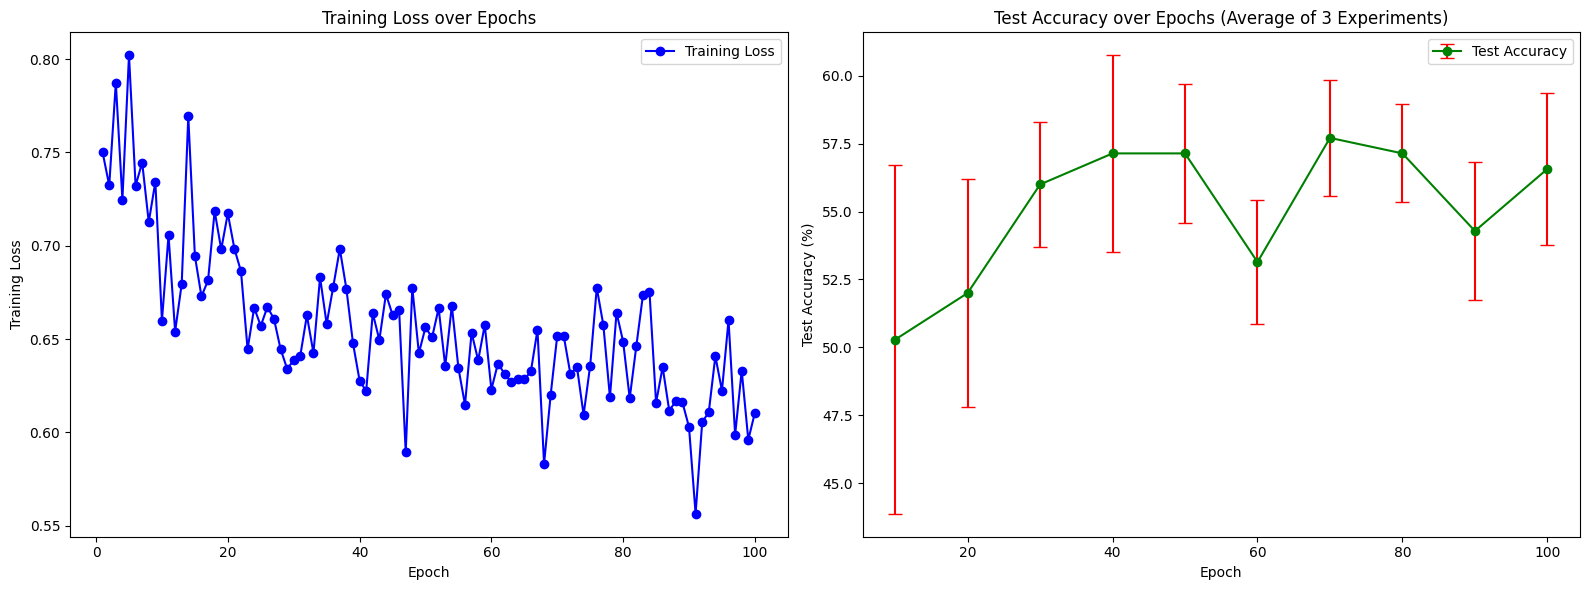

In [463]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

num_experiments = 5
num_epochs = 100

all_epoch_losses = []
all_test_accuracies = []

for experiment in range(num_experiments):
    model = ReactionGNN(node_input_dim, hidden_dim, output_dim, num_global_features).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    criterion = nn.BCEWithLogitsLoss()

    epoch_losses = []  
    test_accuracies = []  #

    for epoch in range(num_epochs):
        model.train() 
        total_loss = 0


        for ditopic_graph, tritopic_graph, label in train_loader:
        
            ditopic_graph = ditopic_graph.to(device)
            tritopic_graph = tritopic_graph.to(device)
            label = label.to(device).float()  

            optimizer.zero_grad()

            out = model(ditopic_graph, tritopic_graph).squeeze()  
            loss = criterion(out, label)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)  

    
        print(f'Experiment {experiment + 1}, Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}')


        if (epoch + 1) % 10 == 0:
            model.eval()  
            correct = 0
            total = 0

            with torch.no_grad():
                for ditopic_graph, tritopic_graph, label in test_loader:  
                    ditopic_graph = ditopic_graph.to(device)
                    tritopic_graph = tritopic_graph.to(device)
                    label = label.to(device)

                    out = model(ditopic_graph, tritopic_graph)

                    probs = torch.sigmoid(out)
                    preds = probs.round()  

                   
                    preds = preds.cpu()
                    label = label.cpu()

             
                    correct += (preds.squeeze() == label).sum().item()
                    total += label.size(0)
            
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy) 
            print(f'Experiment {experiment + 1}, Test Accuracy after Epoch {epoch + 1}: {accuracy:.2f} %')

  
    all_epoch_losses.append(epoch_losses)
    all_test_accuracies.append(test_accuracies)


all_test_accuracies = np.array(all_test_accuracies)


mean_test_accuracies = np.mean(all_test_accuracies, axis=0)
std_test_accuracies = np.std(all_test_accuracies, axis=0)


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(range(1, num_epochs + 1), all_epoch_losses[-1], marker='o', linestyle='-', color='b', label='Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss over Epochs')
axes[0].legend()
axes[0].grid(False)

test_epochs = range(10, num_epochs + 1, 10)
axes[1].errorbar(test_epochs, mean_test_accuracies, yerr=std_test_accuracies, fmt='-o', color='g', ecolor='r', capsize=5, label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('Test Accuracy over Epochs (Average of 3 Experiments)')
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()
